# Imports and datasets creation

In [1]:
import csv
import torch 
import sklearn
import scipy
from scipy import io
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from torch.autograd import Variable
import torchvision
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.utils.data as data
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from sklearn.datasets import make_moons, make_blobs, make_circles
from tqdm.notebook import trange, tqdm
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment as linear_assignment
from typing import Optional
import seaborn as sns

import copy
import random
import time
from math import floor

import os


In [2]:
cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

float_Tensor = torch.FloatTensor
if cuda: float_Tensor = torch.cuda.FloatTensor
	
drop_last = True
shuffle = False

In [3]:
def get_squeezed_gauss_np():
	# Do not normilize!
	data, labels = make_blobs(n_samples=1000, centers=[(0.45, 0.5), (0.55, 0.5)], cluster_std=((0.005, 0.15), (0.005, 0.15)))
	data = data.astype("float")
	labels = labels.astype("int")
	return data, labels

def get_squeezed_gauss_dataloader(batch_size=100):
	data, labels = get_squeezed_gauss_np()

	# Convert to tensor dataset
	data = torch.Tensor(data)
	data_shape = data.shape[1]
	labels = torch.Tensor(labels)
	final_dataset = TensorDataset(data, labels)
	dataloader = DataLoader(final_dataset, batch_size=batch_size, drop_last=drop_last, shuffle=shuffle)

	return dataloader, data_shape

In [4]:
squeezed_dataloader, squeezed_data_shape = get_squeezed_gauss_dataloader(batch_size=100)
squeezed_datapoints, squeezed_labels = get_squeezed_gauss_np()

In [5]:
def get_rings_np():
	data, labels = make_circles(n_samples=1000, factor=0.3, noise=0.05, random_state=0)
	scaler = MinMaxScaler()
	data = scaler.fit_transform(data)
	data = data.astype("float")
	labels = labels.astype("int")
	return data, labels

def get_rings_dataloader(batch_size=64):
	data, labels = get_rings_np()

	# Convert to tensor dataset
	data = torch.Tensor(data)
	data_shape = data.shape[1]
	labels = torch.Tensor(labels)
	final_dataset = TensorDataset(data, labels)
	dataloader = DataLoader(final_dataset, batch_size=batch_size, drop_last=drop_last, shuffle=shuffle)

	return dataloader, data_shape

In [6]:
rings_dataloader, rings_data_shape = get_rings_dataloader(batch_size=64)
rings_datapoints, rings_labels = get_rings_np()

In [7]:
def get_moons_np():
	data, labels = make_moons(n_samples=1_000, noise=0.05, random_state=0)
	scaler = MinMaxScaler()
	data = scaler.fit_transform(data)
	data = data.astype("float")
	labels = labels.astype("int")
	return data, labels

def get_moons_dataloader(batch_size=64):
	data, labels = get_moons_np()

	# Convert to tensor dataset
	data = torch.Tensor(data)
	data_shape = data.shape[1]
	labels = torch.Tensor(labels)
	final_dataset = TensorDataset(data, labels)
	dataloader = DataLoader(final_dataset, batch_size=batch_size, drop_last=drop_last, shuffle=shuffle)

	return dataloader, data_shape

In [8]:
moons_dataloader, moons_data_shape = get_moons_dataloader(batch_size=64)
moons_datapoints, moons_labels = get_moons_np()

# Autoencoder/Custom dataset/function declarations

In [10]:
class CustomDataset(Dataset):
  def __init__(self, datapoints, labels, transform=None):

    self.datapoints = datapoints
    self.labels = labels
    self.transform = transform

  def __getitem__(self, index):
    sample = self.datapoints[index], self.labels[index]

    if self.transform:
      sample = self.transform(sample)

    return sample
  
  def __len__(self):
    return len(self.datapoints)

In [11]:
# TODO: search hungarian algorithm
def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
	"""
	Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
	determine reassignments.

	:param y_true: list of true cluster numbers, an integer array 0-indexed
	:param y_predicted: list of predicted cluster numbers, an integer array 0-indexed
	:param cluster_number: number of clusters, if None then calculated from input
	:return: reassignment dictionary, clustering accuracy
	"""
	if cluster_number is None:
		# assume labels are 0-indexed
		cluster_number = (max(y_predicted.max(), y_true.max()) + 1)
	count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
	for i in range(y_predicted.size):
		count_matrix[y_predicted[i], y_true[i]] += 1

	row_ind, col_ind = linear_assignment(count_matrix.max() - count_matrix)
	reassignment = dict(zip(row_ind, col_ind))
	accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
	return reassignment, accuracy

def transform_clusters_to_labels(clusters, labels):
	# Find the cluster ids (labels)
	c_ids = np.unique(clusters)

	# Dictionary to transform cluster label to real label
	dict_clusters_to_labels = dict()

	# For every cluster find the most frequent data label
	for c_id in c_ids:
		indexes_of_cluster_i = np.where(c_id == clusters)
		elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
		true_label_index = np.argmax(frequency)
		true_label = elements[true_label_index]
		dict_clusters_to_labels[c_id] = true_label

	# Change the cluster labels to real labels
	for i, element in enumerate(clusters):
		clusters[i] = dict_clusters_to_labels[element]

	return clusters



In [12]:
def check_number_of_representatives(Y): # TODO: check for empty clusters
  cluster_map = {}

  for element in Y:
    if element not in cluster_map:
      cluster_map[element] = 1
    else:
      cluster_map[element] += 1

  for cluster_number in cluster_map.keys():
    print("Cluster", cluster_number, ":", cluster_map[cluster_number], "elements \n")

In [13]:
class Autoencoder(nn.Module):
    def __init__(self, input_dimension, hl1_neurons, hl2_neurons, latent_dimension):
        super().__init__()

        # Encoder Model
        self.input_dimension = input_dimension
        self.hl1_neurons = hl1_neurons
        self.hl2_neurons = hl2_neurons
        self.latent_dimension = latent_dimension

        self.encoder_model = nn.Sequential(
          nn.Linear(input_dimension, self.hl1_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, self.hl2_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
        )
        
        # Latent Space
        self.latent_space = nn.Sequential(
          nn.Linear(self.hl2_neurons, self.latent_dimension),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.latent_dimension),
        )

        # Decoder Model
        self.decoder_model = nn.Sequential(
          nn.Linear(self.latent_dimension, self.hl2_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
          nn.Linear(self.hl2_neurons, self.hl1_neurons),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, input_dimension),
          nn.Sigmoid(),
        )

    def forward(self, x):
      x = self.encoder_model(x)
      x = self.latent_space(x)
      x = self.decoder_model(x)
      return x
  
    def encoder(self, x, device):
      x = torch.from_numpy(x).to(device)
      x= x.float()
      x = self.encoder_model(x)
      x = self.latent_space(x)
      return x.cpu().detach().numpy()

In [14]:
def train_autoencoder(device, dataloader, autoencoder, cluster_centroids, cluster_labels, epochs=500):
	criterion = nn.MSELoss().to(device)
	optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)
	loss_list = list()
	batch_size = 64
	
	autoencoder.train()
	for epoch in range(epochs):
		loss = 0
		for batch_index, (batch, labels) in enumerate(dataloader):
			# Data to the GPU (cuda)
			batch = Variable(batch.type(float_Tensor))
			
			# Indexes
			low_index = batch_index * batch_size
			high_index = (batch_index + 1) * batch_size
			
			# Select centroids
			batch_cluster_labels = cluster_labels[low_index:high_index]
			batch_cluster_centroids = cluster_centroids[batch_cluster_labels]
			batch_cluster_centroids = torch.Tensor(batch_cluster_centroids)
			batch_cluster_centroids = Variable(batch_cluster_centroids.type(float_Tensor))
			
			# reset the gradients to zero
			optimizer.zero_grad()
			autoencoder.zero_grad()

			# compute reconstructions
			reconstructions = autoencoder(batch)

			# compute training reconstruction loss
			train_loss = criterion(reconstructions, batch_cluster_centroids)

			# compute accumulated gradients
			train_loss.backward()

			# perform parameter update based on current gradients
			optimizer.step()

			# add the mini-batch training loss to epoch loss
			loss += train_loss.item()

		loss = loss / len(dataloader)
		loss_list.append(loss)
		print("Epoch: {}/{}, Loss: {:.6f}".format(epoch + 1, epochs, loss))
		
	autoencoder.eval()
	return autoencoder, loss_list

# Squeezed gauss clustering

In [ ]:
kmeans_2_clusters = KMeans(n_clusters=2, n_init=100).fit(squeezed_datapoints)
retrieved_labels_2_clusters = transform_clusters_to_labels(kmeans_2_clusters.labels_, squeezed_labels)

print("K_means greedy accuracy score for 2 clusters on initial space:",accuracy_score(squeezed_labels, retrieved_labels_2_clusters))
print("K_means hungarian accuracy score for 2 clusters on initial space:",cluster_accuracy(squeezed_labels, kmeans_2_clusters.labels_)[1])
print("K-means normalised mutual info score for 2 clusters on initial space:",normalized_mutual_info_score(squeezed_labels, kmeans_2_clusters.labels_))
print("K-means ARI for 2 clusters on initial space:",adjusted_rand_score(squeezed_labels, kmeans_2_clusters.labels_))
print("K-means silhouette score for 2 clusters on initial space:",silhouette_score(squeezed_datapoints, kmeans_2_clusters.labels_))

K_means greedy accuracy score for 2 clusters on initial space: 0.542
K_means hungarian accuracy score for 2 clusters on initial space: 0.542
K-means normalised mutual info score for 2 clusters on initial space: 0.005099844579020084
K-means ARI for 2 clusters on initial space: 0.006061639788071625
K-means silhouette score for 2 clusters on initial space: 0.4713488117030361


In [ ]:
aggloClustering_2_clusters = AgglomerativeClustering(n_clusters=2).fit(squeezed_datapoints)
agglo_retrieved_labels = transform_clusters_to_labels(aggloClustering_2_clusters.labels_, squeezed_labels)

# print the stats on agglomerative clustering

print("Agglomerative clustering on initial space greedy accuracy score:",accuracy_score(squeezed_labels, agglo_retrieved_labels))
print("Agglomerative clustering on initial space hungarian accuracy score:",cluster_accuracy(squeezed_labels, aggloClustering_2_clusters.labels_)[1])
print("Normalised mutual info score on agglomerative clustering on initial space:",normalized_mutual_info_score(squeezed_labels, aggloClustering_2_clusters.labels_))
print("Agglomerative clustering ARI on initial space:",adjusted_rand_score(squeezed_labels, aggloClustering_2_clusters.labels_))
print("Agglomerative clustering silhouette score for 10 clusters on initial space:",silhouette_score(squeezed_datapoints, aggloClustering_2_clusters.labels_))

Agglomerative clustering on initial space greedy accuracy score: 0.535
Agglomerative clustering on initial space hungarian accuracy score: 0.535
Normalised mutual info score on agglomerative clustering on initial space: 0.0044031377443383415
Agglomerative clustering ARI on initial space: 0.004051595519513001
Agglomerative clustering silhouette score for 10 clusters on initial space: 0.4566768156698576


In [ ]:
data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(squeezed_datapoints)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.005s...
[t-SNE] Computed neighbors for 1000 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.008081
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.691704
[t-SNE] KL divergence after 400 iterations: 0.355056


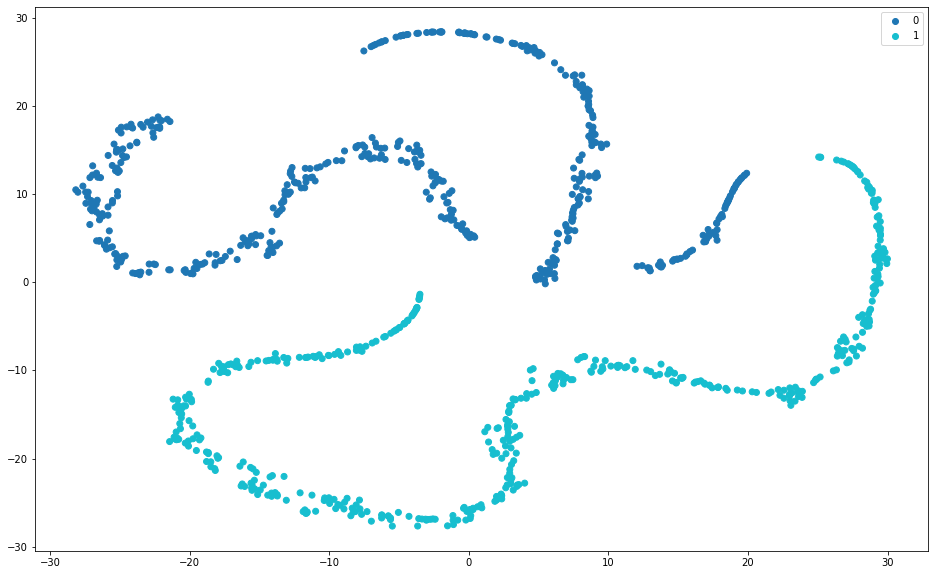

In [ ]:
dataset_labels = [0,1]

plt.figure(figsize=(16,10))
scatterplot = plt.scatter(
    x=data_TSNE[:,0], y=data_TSNE[:,1],
    c=squeezed_labels,
    cmap="tab10"
)

handles, _ = scatterplot.legend_elements(prop='colors')
plt.legend(handles, dataset_labels)

In [17]:
def run_experiment(K, dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension):

  print('Experiment results for k-means with k =', K, 'clusters:\n')
  print('Running k-means algorithm in order to get our pseudolabels: \n')

  kmeans_initial = KMeans(n_clusters=K, n_init=100).fit(datapoints) 
  cluster_centers = kmeans_initial.cluster_centers_
  cluster_labels = kmeans_initial.labels_
  real_labels = transform_clusters_to_labels(cluster_labels, labels)

  x_points = [datapoints[i][0] for i in range(len(datapoints))]
  y_points = [datapoints[j][1] for j in range(len(datapoints))]
  colors = ['r','g','b','c','m','y','cyan','yellow','saddlebrown','indigo','navy' ]
  colors_per_cluster = [colors[c] for c in cluster_labels]

  plt.figure(figsize=(9,7))
  plt.scatter(x=x_points, y=y_points, c=colors_per_cluster)
  # check TSNE representation of our features according to the k categories

  # print("Creating TSNE representation of our features according to the k categories...\n")

  # pseudolabels_indices = [i for i in range(K)]

  # plt.figure(figsize=(16,10)) 
  # kmeans_scatterplot = plt.scatter(
  #     x=data_TSNE[:,0], y=data_TSNE[:,1],
  #     c=cluster_labels,
  #     cmap="gist_rainbow"
  # )

  # handles = kmeans_scatterplot.legend_elements(num=pseudolabels_indices)[0]
  # plt.legend(handles, pseudolabels_indices)

  # savestring = 'pseudolabels_TSNE_initial_space_k=' + str(K) + '.png'
  # plt.savefig(savestring)

  # find out accuracy of the algorithm in the initial space

  kmeans_initial_hungarian_acc = cluster_accuracy(labels, cluster_labels)[1]
  kmeans_initial_NMI = normalized_mutual_info_score(labels, cluster_labels)
  kmeans_initial_ARI = adjusted_rand_score(labels, cluster_labels)

  print("K_means greedy accuracy score (initial space):",accuracy_score(labels, real_labels))
  print("K_means hungarian accuracy score (initial space):",kmeans_initial_hungarian_acc)
  print("Normalised mutual info score (initial space):",kmeans_initial_NMI)
  print("ARI (initial space):",kmeans_initial_ARI, "\n")

  # using the autoencoder model on our data

  print('Using the autoencoder model on our data: \n')

  kmeans_accuracy_scores = []
  k_means_silhouette_scores = []
  k_means_cluster_error_scores = []
  kmeans_NMI_scores = []
  kmeans_ARI_scores = []
  agglo_accuracy_scores = []
  agglo_NMI_scores = []
  agglo_ARI_scores = []
  
  for i in range(5):

    print("ROUND NUMBER ",i + 1,":\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, cluster_centers, cluster_labels, epochs=epochs)
    latent_data = autoencoder.encoder(datapoints, device)

    data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(latent_data)

    dataset_labels = [0,1,2,3,4,5,6,7,8,9]

    plt.figure(figsize=(16,10))
    scatterplot = plt.scatter(
        x=data_TSNE[:,0], y=data_TSNE[:,1],
        c=labels,
        cmap="tab10"
    )

    handles, _ = scatterplot.legend_elements(prop='colors')
    plt.legend(handles, dataset_labels)
    
    print("Creating a k-means model on latent data:\n")

    # Maybe we need Standar Scaler

    # std_scaler = StandardScaler()
    # latent_data = std_scaler.fit_transform(latent_data)

    # Clustering on transformed space

    new_kmeans = KMeans(n_clusters=2, n_init=100).fit(latent_data)

    kmeans_clusters = new_kmeans.labels_
    kmeans_cluster_error = new_kmeans.inertia_
    k_means_cluster_error_scores.append(kmeans_cluster_error)
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, labels)

    # print the stats on the transformed space
    kmeans_greedy_acc = accuracy_score(labels, kmeans_greedy_labels)

    # These metrics as input they use the output of the clustering algorithm
    kmeans_hungarian_acc = cluster_accuracy(labels, kmeans_clusters)[1]
    kmeans_NMI = normalized_mutual_info_score(labels, kmeans_clusters)
    kmeans_ARI = adjusted_rand_score(labels, kmeans_clusters)

    kmeans_accuracy_scores.append(kmeans_hungarian_acc)
    kmeans_NMI_scores.append(kmeans_NMI)
    kmeans_ARI_scores.append(kmeans_ARI)

    k_means_silhouette_score = silhouette_score(latent_data, kmeans_clusters)
    k_means_silhouette_scores.append(k_means_silhouette_score)

    print("K-means with 10 clusters on latent space stats: \n")
    print("K-means on latent space greedy accuracy score:",kmeans_greedy_acc)
    print("K-means on latent space hungarian accuracy score:",kmeans_hungarian_acc)
    print("Normalised mutual info score on k-means on latent space:", kmeans_NMI)
    print("ARI score on k-means on latent space:", kmeans_ARI)
    print("K-means cluster error on latent space:", kmeans_cluster_error)
    print("K-means silhouette score on latent space:", k_means_silhouette_score, "\n")

    # do agglomerative clustering on the transformed space

    print("Doing agglomerative clustering on MLP output vectors:\n")
    aggloClustering = AgglomerativeClustering(n_clusters=2).fit(latent_data)
    aggloClustering_clusters = aggloClustering.labels_
    agglo_greedy_labels = transform_clusters_to_labels(aggloClustering_clusters, labels)

    # print the stats on agglomerative clustering
    agglo_greedy_acc = accuracy_score(labels, agglo_greedy_labels)
    agglo_hungarian_acc = cluster_accuracy(labels, aggloClustering_clusters)[1]
    agglo_NMI = normalized_mutual_info_score(labels, aggloClustering_clusters)
    agglo_ARI = adjusted_rand_score(labels, aggloClustering_clusters)

    agglo_accuracy_scores.append(agglo_greedy_acc)
    agglo_NMI_scores.append(agglo_NMI)
    agglo_ARI_scores.append(agglo_ARI)

    print("Agglomerative clustering on latent space greedy accuracy score:", agglo_greedy_acc)
    print("Agglomerative clustering on latent space hungarian accuracy score:", agglo_hungarian_acc)
    print("Normalised mutual info score on agglomerative clustering on latent space:",agglo_NMI, "\n")
    print("ARI score on agglomerative clustering on latent space:", agglo_ARI, "\n")

  print("Average k-means accuracy score at latent space:", sum(kmeans_accuracy_scores) / len(kmeans_accuracy_scores), "\n")
  print("Average k-means NMI score at latent space:", sum(kmeans_NMI_scores) / len(kmeans_NMI_scores), "\n")
  print("Average k-means ARI score at latent space:", sum(kmeans_ARI_scores) / len(kmeans_ARI_scores), "\n")
  print("Average agglomerative clustering accuracy score at latent space:", sum(agglo_accuracy_scores) / len(agglo_accuracy_scores), "\n")
  print("Average agglomerative clustering NMI score at latent space:", sum(agglo_NMI_scores) / len(agglo_NMI_scores), "\n")
  print("Average agglomerative clustering ARI score at latent space:", sum(agglo_ARI_scores) / len(agglo_ARI_scores), "\n")
  print("Average k-means silhouette score on latent space:", sum(k_means_silhouette_scores) / len(k_means_silhouette_scores), "\n")
  print("Average k-means cluster error on latent space:", sum(k_means_cluster_error_scores) / len(k_means_cluster_error_scores), "\n")

  return [ kmeans_accuracy_scores, kmeans_NMI_scores, kmeans_ARI_scores, agglo_accuracy_scores, agglo_NMI_scores, agglo_ARI_scores, k_means_silhouette_scores]

In [ ]:
results_for_k_5 = run_experiment(5, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 5 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.724
K_means hungarian accuracy score (initial space): 0.724
Normalised mutual info score (initial space): 0.18031392474081817
ARI (initial space): 0.19998934303258434 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.003427
Epoch: 2/50, Loss: 0.002891
Epoch: 3/50, Loss: 0.002851
Epoch: 4/50, Loss: 0.002711
Epoch: 5/50, Loss: 0.002661
Epoch: 6/50, Loss: 0.002630
Epoch: 7/50, Loss: 0.002608
Epoch: 8/50, Loss: 0.002585
Epoch: 9/50, Loss: 0.002578
Epoch: 10/50, Loss: 0.002573
Epoch: 11/50, Loss: 0.002570
Epoch: 12/50, Loss: 0.002568
Epoch: 13/50, Loss: 0.002568
Epoch: 14/50, Loss: 0.002568
Epoch: 15/50, Loss: 0.002568
Epoch: 16/50, Loss: 0.002568
Epoch: 17/50, Loss: 0.002567
Epoch: 18/50, Loss: 0.002567
Epoch: 19/50, Loss: 0.002567
Epoch: 20/50, Loss: 0.002567
Epoch: 21/50, Loss: 0.002566
Epoch

In [ ]:
results_for_k_10 = run_experiment(10, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 10 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.956
K_means hungarian accuracy score (initial space): 0.956
Normalised mutual info score (initial space): 0.7817135456394719
ARI (initial space): 0.8315767136973238 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.011242
Epoch: 2/50, Loss: 0.009546
Epoch: 3/50, Loss: 0.009158
Epoch: 4/50, Loss: 0.008814
Epoch: 5/50, Loss: 0.008552
Epoch: 6/50, Loss: 0.008281
Epoch: 7/50, Loss: 0.008033
Epoch: 8/50, Loss: 0.007808
Epoch: 9/50, Loss: 0.007592
Epoch: 10/50, Loss: 0.007395
Epoch: 11/50, Loss: 0.007213
Epoch: 12/50, Loss: 0.007043
Epoch: 13/50, Loss: 0.006888
Epoch: 14/50, Loss: 0.006745
Epoch: 15/50, Loss: 0.006614
Epoch: 16/50, Loss: 0.006494
Epoch: 17/50, Loss: 0.006386
Epoch: 18/50, Loss: 0.006287
Epoch: 19/50, Loss: 0.006198
Epoch: 20/50, Loss: 0.006118
Epoch: 21/50, Loss: 0.006046
Epoch:

In [ ]:
results_for_k_15 = run_experiment(15, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 15 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.997
K_means hungarian accuracy score (initial space): 0.997
Normalised mutual info score (initial space): 0.9735291317877252
ARI (initial space): 0.9880240124560477 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.012955
Epoch: 2/50, Loss: 0.010383
Epoch: 3/50, Loss: 0.009779
Epoch: 4/50, Loss: 0.009506
Epoch: 5/50, Loss: 0.009339
Epoch: 6/50, Loss: 0.009148
Epoch: 7/50, Loss: 0.009015
Epoch: 8/50, Loss: 0.008875
Epoch: 9/50, Loss: 0.008756
Epoch: 10/50, Loss: 0.008649
Epoch: 11/50, Loss: 0.008551
Epoch: 12/50, Loss: 0.008465
Epoch: 13/50, Loss: 0.008387
Epoch: 14/50, Loss: 0.008320
Epoch: 15/50, Loss: 0.008260
Epoch: 16/50, Loss: 0.008208
Epoch: 17/50, Loss: 0.008162
Epoch: 18/50, Loss: 0.008122
Epoch: 19/50, Loss: 0.008088
Epoch: 20/50, Loss: 0.008059
Epoch: 21/50, Loss: 0.008035
Epoch:

In [ ]:
results_for_k_20 = run_experiment(20, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 20 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.998
K_means hungarian accuracy score (initial space): 0.998
Normalised mutual info score (initial space): 0.981182940453905
ARI (initial space): 0.9920080001281283 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.014931
Epoch: 2/50, Loss: 0.013087
Epoch: 3/50, Loss: 0.012737
Epoch: 4/50, Loss: 0.012406
Epoch: 5/50, Loss: 0.012083
Epoch: 6/50, Loss: 0.011804
Epoch: 7/50, Loss: 0.011526
Epoch: 8/50, Loss: 0.011269
Epoch: 9/50, Loss: 0.011026
Epoch: 10/50, Loss: 0.010795
Epoch: 11/50, Loss: 0.010579
Epoch: 12/50, Loss: 0.010375
Epoch: 13/50, Loss: 0.010183
Epoch: 14/50, Loss: 0.010004
Epoch: 15/50, Loss: 0.009838
Epoch: 16/50, Loss: 0.009683
Epoch: 17/50, Loss: 0.009540
Epoch: 18/50, Loss: 0.009409
Epoch: 19/50, Loss: 0.009288
Epoch: 20/50, Loss: 0.009177
Epoch: 21/50, Loss: 0.009077
Epoch: 

In [ ]:
results_for_k_25 = run_experiment(25, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 25 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.998
K_means hungarian accuracy score (initial space): 0.998
Normalised mutual info score (initial space): 0.981182940453905
ARI (initial space): 0.9920080001281283 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.021832
Epoch: 2/50, Loss: 0.018868
Epoch: 3/50, Loss: 0.018370
Epoch: 4/50, Loss: 0.017965
Epoch: 5/50, Loss: 0.017650
Epoch: 6/50, Loss: 0.017356
Epoch: 7/50, Loss: 0.017080
Epoch: 8/50, Loss: 0.016828
Epoch: 9/50, Loss: 0.016590
Epoch: 10/50, Loss: 0.016369
Epoch: 11/50, Loss: 0.016162
Epoch: 12/50, Loss: 0.015970
Epoch: 13/50, Loss: 0.015791
Epoch: 14/50, Loss: 0.015626
Epoch: 15/50, Loss: 0.015472
Epoch: 16/50, Loss: 0.015331
Epoch: 17/50, Loss: 0.015201
Epoch: 18/50, Loss: 0.015081
Epoch: 19/50, Loss: 0.014971
Epoch: 20/50, Loss: 0.014871
Epoch: 21/50, Loss: 0.014780
Epoch: 

In [ ]:
results_for_k_30 = run_experiment(30, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 30 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.999
K_means hungarian accuracy score (initial space): 0.999
Normalised mutual info score (initial space): 0.9895915066199539
ARI (initial space): 0.995999996008016 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.019509
Epoch: 2/50, Loss: 0.016563
Epoch: 3/50, Loss: 0.016166
Epoch: 4/50, Loss: 0.015860
Epoch: 5/50, Loss: 0.015588
Epoch: 6/50, Loss: 0.015337
Epoch: 7/50, Loss: 0.015101
Epoch: 8/50, Loss: 0.014886
Epoch: 9/50, Loss: 0.014684
Epoch: 10/50, Loss: 0.014501
Epoch: 11/50, Loss: 0.014324
Epoch: 12/50, Loss: 0.014166
Epoch: 13/50, Loss: 0.014011
Epoch: 14/50, Loss: 0.013877
Epoch: 15/50, Loss: 0.013749
Epoch: 16/50, Loss: 0.013634
Epoch: 17/50, Loss: 0.013528
Epoch: 18/50, Loss: 0.013438
Epoch: 19/50, Loss: 0.013350
Epoch: 20/50, Loss: 0.013281
Epoch: 21/50, Loss: 0.013194
Epoch: 

In [ ]:
results_for_k_35 = run_experiment(35, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 35 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.015238
Epoch: 2/50, Loss: 0.012198
Epoch: 3/50, Loss: 0.011925
Epoch: 4/50, Loss: 0.011758
Epoch: 5/50, Loss: 0.011594
Epoch: 6/50, Loss: 0.011479
Epoch: 7/50, Loss: 0.011356
Epoch: 8/50, Loss: 0.011262
Epoch: 9/50, Loss: 0.011171
Epoch: 10/50, Loss: 0.011098
Epoch: 11/50, Loss: 0.011031
Epoch: 12/50, Loss: 0.010975
Epoch: 13/50, Loss: 0.010927
Epoch: 14/50, Loss: 0.010886
Epoch: 15/50, Loss: 0.010851
Epoch: 16/50, Loss: 0.010823
Epoch: 17/50, Loss: 0.010799
Epoch: 18/50, Loss: 0.010779
Epoch: 19/50, Loss: 0.010763
Epoch: 20/50, Loss: 0.010750
Epoch: 21/50, Loss: 0.010739
Epoch: 22/50, Loss: 0.010731
Epoch: 23/5

In [ ]:
results_for_k_40 = run_experiment(40, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 40 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.014533
Epoch: 2/50, Loss: 0.009945
Epoch: 3/50, Loss: 0.009340
Epoch: 4/50, Loss: 0.009109
Epoch: 5/50, Loss: 0.008914
Epoch: 6/50, Loss: 0.008779
Epoch: 7/50, Loss: 0.008652
Epoch: 8/50, Loss: 0.008547
Epoch: 9/50, Loss: 0.008454
Epoch: 10/50, Loss: 0.008376
Epoch: 11/50, Loss: 0.008307
Epoch: 12/50, Loss: 0.008249
Epoch: 13/50, Loss: 0.008200
Epoch: 14/50, Loss: 0.008159
Epoch: 15/50, Loss: 0.008124
Epoch: 16/50, Loss: 0.008095
Epoch: 17/50, Loss: 0.008071
Epoch: 18/50, Loss: 0.008052
Epoch: 19/50, Loss: 0.008036
Epoch: 20/50, Loss: 0.008023
Epoch: 21/50, Loss: 0.008013
Epoch: 22/50, Loss: 0.008005
Epoch: 23/5

In [ ]:
results_for_k_45 = run_experiment(45, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 45 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.014762
Epoch: 2/50, Loss: 0.012932
Epoch: 3/50, Loss: 0.012597
Epoch: 4/50, Loss: 0.012289
Epoch: 5/50, Loss: 0.012026
Epoch: 6/50, Loss: 0.011771
Epoch: 7/50, Loss: 0.011545
Epoch: 8/50, Loss: 0.011332
Epoch: 9/50, Loss: 0.011137
Epoch: 10/50, Loss: 0.010955
Epoch: 11/50, Loss: 0.010788
Epoch: 12/50, Loss: 0.010633
Epoch: 13/50, Loss: 0.010492
Epoch: 14/50, Loss: 0.010362
Epoch: 15/50, Loss: 0.010244
Epoch: 16/50, Loss: 0.010136
Epoch: 17/50, Loss: 0.010038
Epoch: 18/50, Loss: 0.009950
Epoch: 19/50, Loss: 0.009870
Epoch: 20/50, Loss: 0.009798
Epoch: 21/50, Loss: 0.009734
Epoch: 22/50, Loss: 0.009677
Epoch: 23/5

In [ ]:
results_for_k_50 = run_experiment(50, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 50 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.005881
Epoch: 2/50, Loss: 0.005118
Epoch: 3/50, Loss: 0.005063
Epoch: 4/50, Loss: 0.005039
Epoch: 5/50, Loss: 0.005039
Epoch: 6/50, Loss: 0.005027
Epoch: 7/50, Loss: 0.005032
Epoch: 8/50, Loss: 0.005033
Epoch: 9/50, Loss: 0.005034
Epoch: 10/50, Loss: 0.005035
Epoch: 11/50, Loss: 0.005035
Epoch: 12/50, Loss: 0.005036
Epoch: 13/50, Loss: 0.005037
Epoch: 14/50, Loss: 0.005037
Epoch: 15/50, Loss: 0.005037
Epoch: 16/50, Loss: 0.005038
Epoch: 17/50, Loss: 0.005038
Epoch: 18/50, Loss: 0.005038
Epoch: 19/50, Loss: 0.005038
Epoch: 20/50, Loss: 0.005038
Epoch: 21/50, Loss: 0.005039
Epoch: 22/50, Loss: 0.005039
Epoch: 23/5

KeyboardInterrupt: ignored

Experiment results for k-means with k = 55 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.012227
Epoch: 2/50, Loss: 0.010933
Epoch: 3/50, Loss: 0.010754
Epoch: 4/50, Loss: 0.010612
Epoch: 5/50, Loss: 0.010512
Epoch: 6/50, Loss: 0.010418
Epoch: 7/50, Loss: 0.010346
Epoch: 8/50, Loss: 0.010283
Epoch: 9/50, Loss: 0.010234
Epoch: 10/50, Loss: 0.010192
Epoch: 11/50, Loss: 0.010160
Epoch: 12/50, Loss: 0.010134
Epoch: 13/50, Loss: 0.010113
Epoch: 14/50, Loss: 0.010097
Epoch: 15/50, Loss: 0.010085
Epoch: 16/50, Loss: 0.010076
Epoch: 17/50, Loss: 0.010069
Epoch: 18/50, Loss: 0.010064
Epoch: 19/50, Loss: 0.010060
Epoch: 20/50, Loss: 0.010058
Epoch: 21/50, Loss: 0.010056
Epoch: 22/50, Loss: 0.010054
Epoch: 23/5

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000197
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.530285
[t-SNE] KL divergence after 400 iterations: 0.272461
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 1.0
K-means on latent space hungarian accuracy score: 1.0
Normalised mutual info score on k-means on latent space: 1.0
ARI score on k-means on latent space: 1.0
K-means cluster error on latent space: 0.08015016466379166
K-means silhouette score on latent space: 0.9958942 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 1.0
Agglomerative clustering on latent space hungarian accuracy score: 1.0
Normalised mutual info score on agglomerative clustering on latent space: 1.0 

ARI score on agglomerative clustering on latent space: 1.0 

ROUND NUMBER  2 :

Epoch: 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.732800


KeyboardInterrupt: ignored

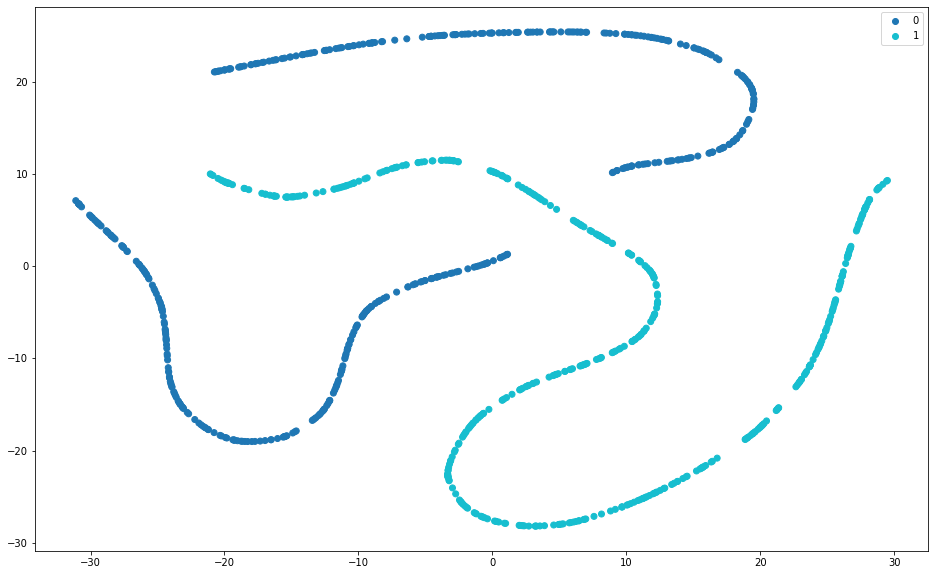

In [ ]:
results_for_k_55 = run_experiment(55, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

In [ ]:
results_for_k_60 = run_experiment(60, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 60 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.006286
Epoch: 2/50, Loss: 0.003667
Epoch: 3/50, Loss: 0.003421
Epoch: 4/50, Loss: 0.003249
Epoch: 5/50, Loss: 0.003100
Epoch: 6/50, Loss: 0.002974
Epoch: 7/50, Loss: 0.002862
Epoch: 8/50, Loss: 0.002766
Epoch: 9/50, Loss: 0.002683
Epoch: 10/50, Loss: 0.002612
Epoch: 11/50, Loss: 0.002551
Epoch: 12/50, Loss: 0.002500
Epoch: 13/50, Loss: 0.002457
Epoch: 14/50, Loss: 0.002421
Epoch: 15/50, Loss: 0.002392
Epoch: 16/50, Loss: 0.002368
Epoch: 17/50, Loss: 0.002348
Epoch: 18/50, Loss: 0.002333
Epoch: 19/50, Loss: 0.002320
Epoch: 20/50, Loss: 0.002311
Epoch: 21/50, Loss: 0.002303
Epoch: 22/50, Loss: 0.002297
Epoch: 23/5

In [ ]:
kmeans_acc = np.zeros((5,12))
kmeans_NMI = np.zeros((5,12))
kmeans_ARI = np.zeros((5,12))
agglo_acc = np.zeros((5,12))
agglo_NMI = np.zeros((5,12))
agglo_ARI = np.zeros((5,12))
kmeans_silhouette = np.zeros((5,12))

for i in range(5):
  
  kmeans_acc[i][0] = results_for_k_5[0][i]
  kmeans_acc[i][1] = results_for_k_10[0][i]
  kmeans_acc[i][2] = results_for_k_15[0][i]
  kmeans_acc[i][3] = results_for_k_20[0][i]
  kmeans_acc[i][4] = results_for_k_25[0][i]
  kmeans_acc[i][5] = results_for_k_30[0][i]
  kmeans_acc[i][6] = results_for_k_35[0][i]
  kmeans_acc[i][7] = results_for_k_40[0][i]
  kmeans_acc[i][8] = results_for_k_45[0][i]
  kmeans_acc[i][9] = results_for_k_50[0][i]
  kmeans_acc[i][10] = results_for_k_55[0][i]
  kmeans_acc[i][11] = results_for_k_60[0][i]

  kmeans_NMI[i][0] = results_for_k_5[1][i]
  kmeans_NMI[i][1] = results_for_k_10[1][i]
  kmeans_NMI[i][2] = results_for_k_15[1][i]
  kmeans_NMI[i][3] = results_for_k_20[1][i]
  kmeans_NMI[i][4] = results_for_k_25[1][i]
  kmeans_NMI[i][5] = results_for_k_30[1][i]
  kmeans_NMI[i][6] = results_for_k_35[1][i]
  kmeans_NMI[i][7] = results_for_k_40[1][i]
  kmeans_NMI[i][8] = results_for_k_45[1][i]
  kmeans_NMI[i][9] = results_for_k_50[1][i]
  kmeans_NMI[i][10] = results_for_k_55[1][i]
  kmeans_NMI[i][11] = results_for_k_60[1][i]

  kmeans_ARI[i][0] = results_for_k_5[2][i]
  kmeans_ARI[i][1] = results_for_k_10[2][i]
  kmeans_ARI[i][2] = results_for_k_15[2][i]
  kmeans_ARI[i][3] = results_for_k_20[2][i]
  kmeans_ARI[i][4] = results_for_k_25[2][i]
  kmeans_ARI[i][5] = results_for_k_30[2][i]
  kmeans_ARI[i][6] = results_for_k_35[2][i]
  kmeans_ARI[i][7] = results_for_k_40[2][i]
  kmeans_ARI[i][8] = results_for_k_45[2][i]
  kmeans_ARI[i][9] = results_for_k_50[2][i]
  kmeans_ARI[i][10] = results_for_k_55[2][i]
  kmeans_ARI[i][11] = results_for_k_60[2][i]

  agglo_acc[i][0] = results_for_k_5[3][i]
  agglo_acc[i][1] = results_for_k_10[3][i]
  agglo_acc[i][2] = results_for_k_15[3][i]
  agglo_acc[i][3] = results_for_k_20[3][i]
  agglo_acc[i][4] = results_for_k_25[3][i]
  agglo_acc[i][5] = results_for_k_30[3][i]
  agglo_acc[i][6] = results_for_k_35[3][i]
  agglo_acc[i][7] = results_for_k_40[3][i]
  agglo_acc[i][8] = results_for_k_45[3][i]
  agglo_acc[i][9] = results_for_k_50[3][i]
  agglo_acc[i][10] = results_for_k_55[3][i]
  agglo_acc[i][11] = results_for_k_60[3][i]

  agglo_NMI[i][0] = results_for_k_5[4][i]
  agglo_NMI[i][1] = results_for_k_10[4][i]
  agglo_NMI[i][2] = results_for_k_15[4][i]
  agglo_NMI[i][3] = results_for_k_20[4][i]
  agglo_NMI[i][4] = results_for_k_25[4][i]
  agglo_NMI[i][5] = results_for_k_30[4][i]
  agglo_NMI[i][6] = results_for_k_35[4][i]
  agglo_NMI[i][7] = results_for_k_40[4][i]
  agglo_NMI[i][8] = results_for_k_45[4][i]
  agglo_NMI[i][9] = results_for_k_50[4][i]
  agglo_NMI[i][10] = results_for_k_55[4][i]
  agglo_NMI[i][11] = results_for_k_60[4][i]

  agglo_ARI[i][0] = results_for_k_5[5][i]
  agglo_ARI[i][1] = results_for_k_10[5][i]
  agglo_ARI[i][2] = results_for_k_15[5][i]
  agglo_ARI[i][3] = results_for_k_20[5][i]
  agglo_ARI[i][4] = results_for_k_25[5][i]
  agglo_ARI[i][5] = results_for_k_30[5][i]
  agglo_ARI[i][6] = results_for_k_35[5][i]
  agglo_ARI[i][7] = results_for_k_40[5][i]
  agglo_ARI[i][8] = results_for_k_45[5][i]
  agglo_ARI[i][9] = results_for_k_50[5][i]
  agglo_ARI[i][10] = results_for_k_55[5][i]
  agglo_ARI[i][11] = results_for_k_60[5][i]

  kmeans_silhouette[i][0] = results_for_k_5[6][i]
  kmeans_silhouette[i][1] = results_for_k_10[6][i]
  kmeans_silhouette[i][2] = results_for_k_15[6][i]
  kmeans_silhouette[i][3] = results_for_k_20[6][i]
  kmeans_silhouette[i][4] = results_for_k_25[6][i]
  kmeans_silhouette[i][5] = results_for_k_30[6][i]
  kmeans_silhouette[i][6] = results_for_k_35[6][i]
  kmeans_silhouette[i][7] = results_for_k_40[6][i]
  kmeans_silhouette[i][8] = results_for_k_45[6][i]
  kmeans_silhouette[i][9] = results_for_k_50[6][i]
  kmeans_silhouette[i][10] = results_for_k_55[6][i]
  kmeans_silhouette[i][11] = results_for_k_60[6][i]


Text(0.5, 0, 'K')

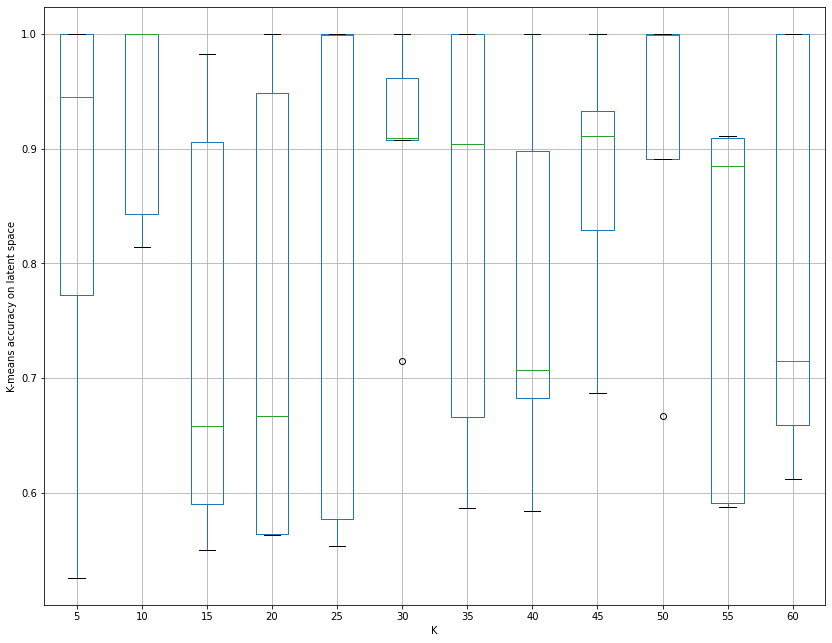

In [ ]:
columns = ['5', '10','15', '20', '25', '30', '35', '40', '45', '50', '55', '60']

df = pd.DataFrame(kmeans_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

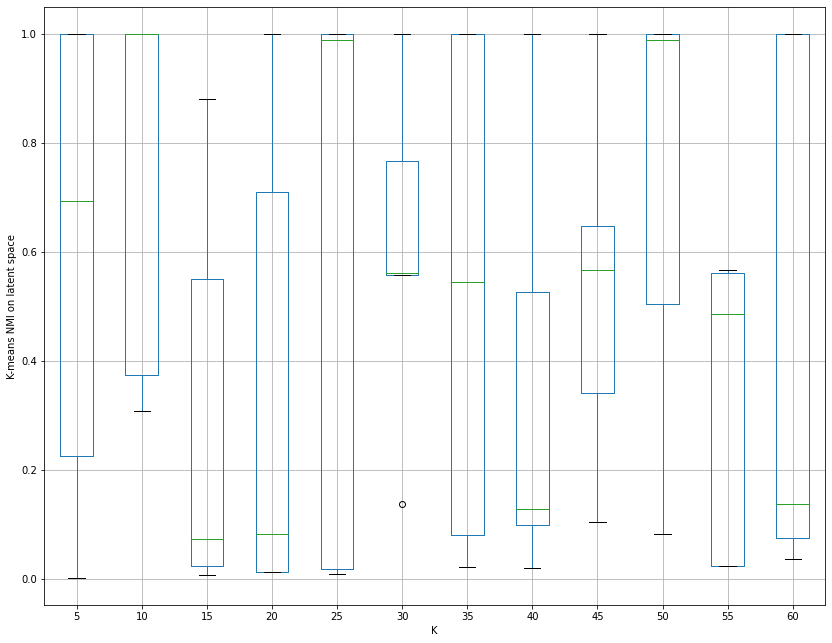

In [ ]:
df = pd.DataFrame(kmeans_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

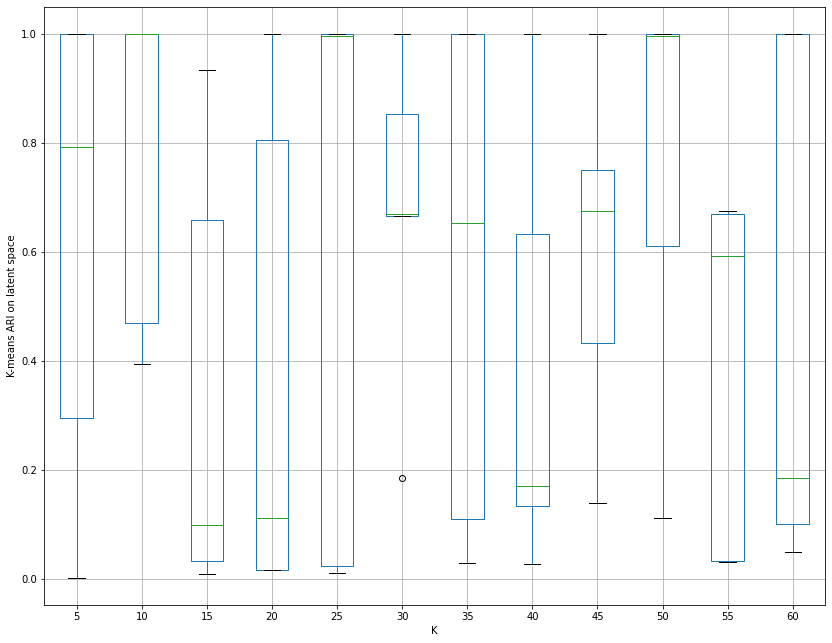

In [ ]:
df = pd.DataFrame(kmeans_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

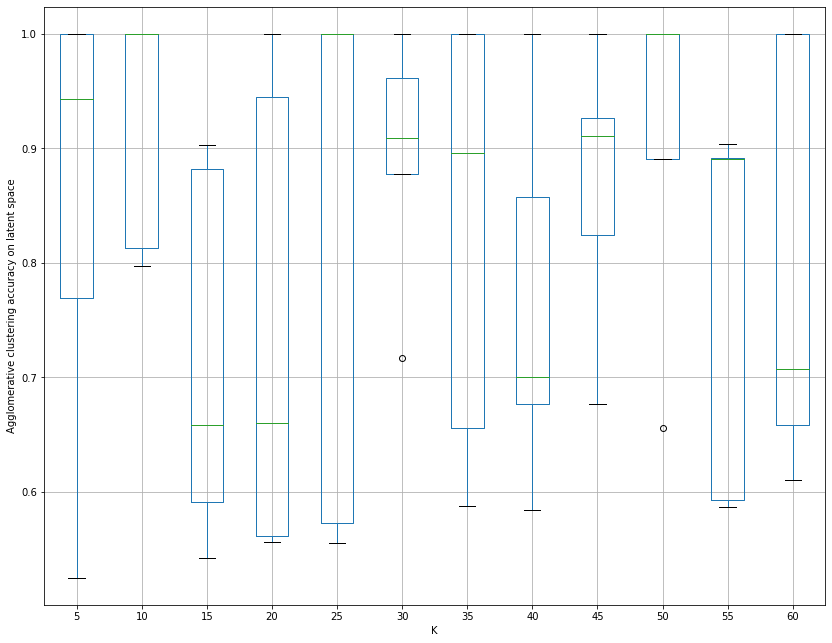

In [ ]:
df = pd.DataFrame(agglo_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

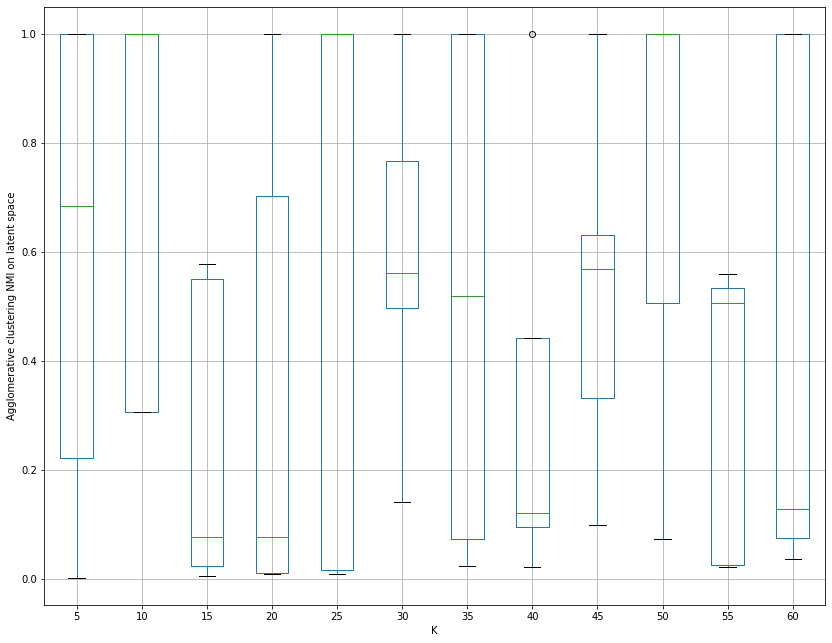

In [ ]:
df = pd.DataFrame(agglo_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

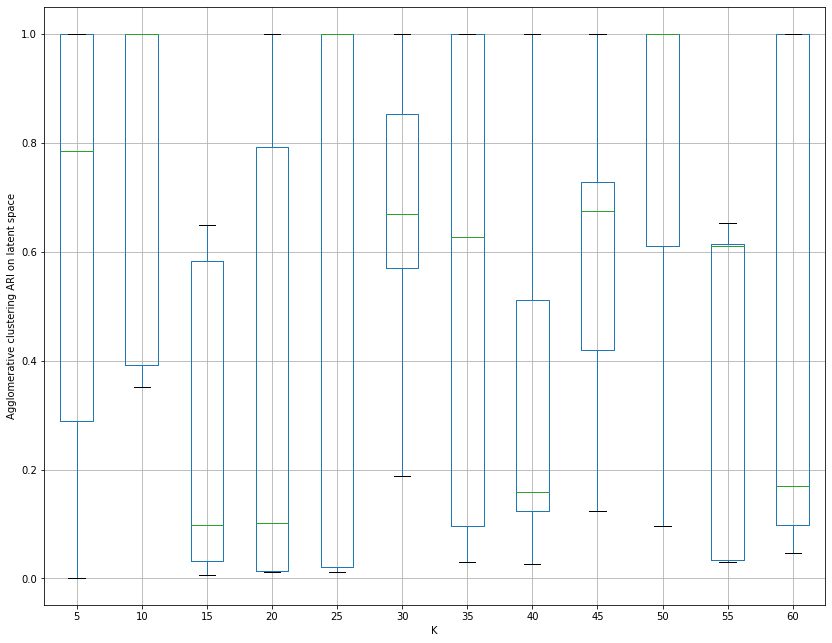

In [ ]:
df = pd.DataFrame(agglo_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

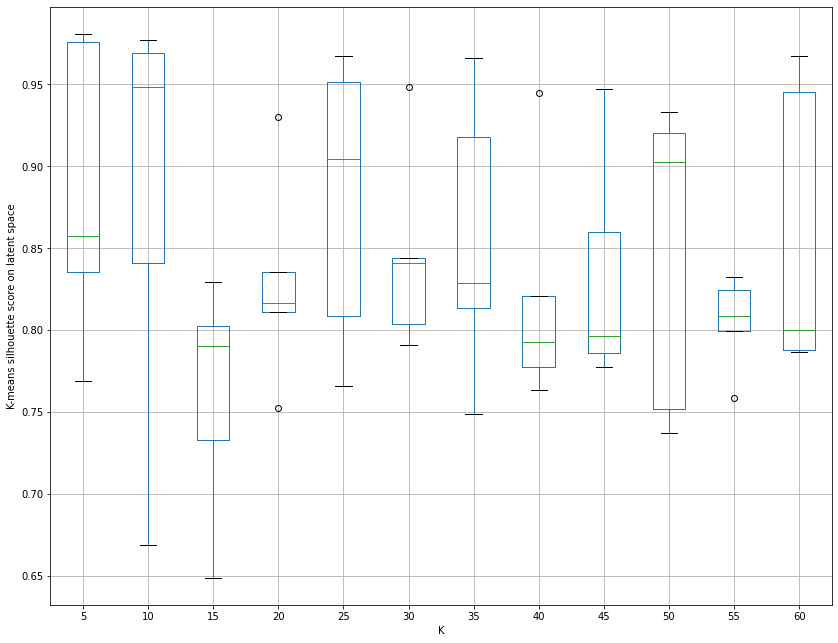

In [ ]:
df = pd.DataFrame(kmeans_silhouette,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means silhouette score on latent space')
boxplot.set_xlabel('K')

# Rings clustering

In [ ]:
kmeans_2_clusters = KMeans(n_clusters=2, n_init=100).fit(rings_datapoints)
retrieved_labels_2_clusters = transform_clusters_to_labels(kmeans_2_clusters.labels_, rings_labels)

print("K_means greedy accuracy score for 2 clusters on initial space:",accuracy_score(rings_labels, retrieved_labels_2_clusters))
print("K_means hungarian accuracy score for 2 clusters on initial space:",cluster_accuracy(rings_labels, kmeans_2_clusters.labels_)[1])
print("K-means normalised mutual info score for 2 clusters on initial space:",normalized_mutual_info_score(rings_labels, kmeans_2_clusters.labels_))
print("K-means ARI for 2 clusters on initial space:",adjusted_rand_score(rings_labels, kmeans_2_clusters.labels_))
print("K-means silhouette score for 2 clusters on initial space:",silhouette_score(rings_datapoints, kmeans_2_clusters.labels_))

K_means greedy accuracy score for 2 clusters on initial space: 0.503
K_means hungarian accuracy score for 2 clusters on initial space: 0.503
K-means normalised mutual info score for 2 clusters on initial space: 2.5969938683868158e-05
K-means ARI for 2 clusters on initial space: -0.0009659318288842226
K-means silhouette score for 2 clusters on initial space: 0.3028383731758318


In [ ]:
aggloClustering_2_clusters = AgglomerativeClustering(n_clusters=2).fit(rings_datapoints)
agglo_retrieved_labels = transform_clusters_to_labels(aggloClustering_2_clusters.labels_, rings_labels)

# print the stats on agglomerative clustering

print("Agglomerative clustering on initial space greedy accuracy score:",accuracy_score(rings_labels, agglo_retrieved_labels))
print("Agglomerative clustering on initial space hungarian accuracy score:",cluster_accuracy(rings_labels, aggloClustering_2_clusters.labels_)[1])
print("Normalised mutual info score on agglomerative clustering on initial space:",normalized_mutual_info_score(rings_labels, aggloClustering_2_clusters.labels_))
print("Agglomerative clustering ARI on initial space:",adjusted_rand_score(rings_labels, aggloClustering_2_clusters.labels_))
print("Agglomerative clustering silhouette score for 10 clusters on initial space:",silhouette_score(rings_datapoints, aggloClustering_2_clusters.labels_))

Agglomerative clustering on initial space greedy accuracy score: 0.713
Agglomerative clustering on initial space hungarian accuracy score: 0.713
Normalised mutual info score on agglomerative clustering on initial space: 0.2920222303745548
Agglomerative clustering ARI on initial space: 0.18092624162887083
Agglomerative clustering silhouette score for 10 clusters on initial space: 0.363527922566883


In [ ]:
data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(rings_datapoints)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.024617
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.924011
[t-SNE] KL divergence after 400 iterations: 0.387067


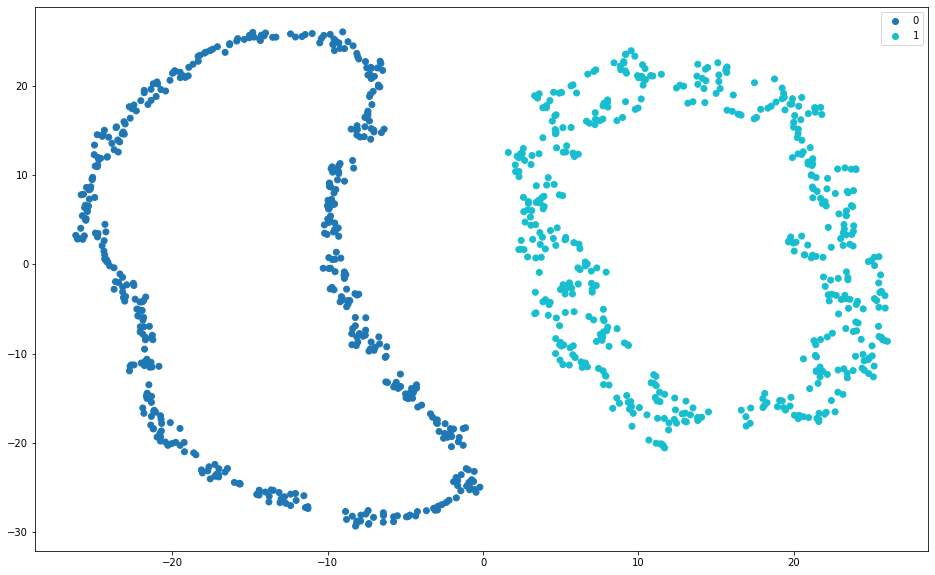

In [ ]:
dataset_labels = [0,1]

plt.figure(figsize=(16,10))
scatterplot = plt.scatter(
    x=data_TSNE[:,0], y=data_TSNE[:,1],
    c=rings_labels,
    cmap="tab10"
)

handles, _ = scatterplot.legend_elements(prop='colors')
plt.legend(handles, dataset_labels)

In [ ]:
def run_experiment(K, dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension):

  print('Experiment results for k-means with k =', K, 'clusters:\n')
  print('Running k-means algorithm in order to get our pseudolabels: \n')

  kmeans_initial = KMeans(n_clusters=K, n_init=100).fit(datapoints) 
  cluster_centers = kmeans_initial.cluster_centers_
  cluster_labels = kmeans_initial.labels_
  real_labels = transform_clusters_to_labels(cluster_labels, labels)

  # check TSNE representation of our features according to the k categories

  # print("Creating TSNE representation of our features according to the k categories...\n")

  # pseudolabels_indices = [i for i in range(K)]

  # plt.figure(figsize=(16,10)) 
  # kmeans_scatterplot = plt.scatter(
  #     x=data_TSNE[:,0], y=data_TSNE[:,1],
  #     c=cluster_labels,
  #     cmap="gist_rainbow"
  # )

  # handles = kmeans_scatterplot.legend_elements(num=pseudolabels_indices)[0]
  # plt.legend(handles, pseudolabels_indices)

  # savestring = 'pseudolabels_TSNE_initial_space_k=' + str(K) + '.png'
  # plt.savefig(savestring)

  # find out accuracy of the algorithm in the initial space

  kmeans_initial_hungarian_acc = cluster_accuracy(labels, cluster_labels)[1]
  kmeans_initial_NMI = normalized_mutual_info_score(labels, cluster_labels)
  kmeans_initial_ARI = adjusted_rand_score(labels, cluster_labels)

  print("K_means greedy accuracy score (initial space):",accuracy_score(labels, real_labels))
  print("K_means hungarian accuracy score (initial space):",kmeans_initial_hungarian_acc)
  print("Normalised mutual info score (initial space):",kmeans_initial_NMI)
  print("ARI (initial space):",kmeans_initial_ARI, "\n")

  # using the autoencoder model on our data

  print('Using the autoencoder model on our data: \n')

  kmeans_accuracy_scores = []
  k_means_silhouette_scores = []
  k_means_cluster_error_scores = []
  kmeans_NMI_scores = []
  kmeans_ARI_scores = []
  agglo_accuracy_scores = []
  agglo_NMI_scores = []
  agglo_ARI_scores = []
  
  for i in range(5):

    print("ROUND NUMBER ",i + 1,":\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, cluster_centers, cluster_labels, epochs=epochs)
    latent_data = autoencoder.encoder(datapoints, device)

    data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(latent_data)

    dataset_labels = [0,1]

    plt.figure(figsize=(16,10))
    scatterplot = plt.scatter(
        x=data_TSNE[:,0], y=data_TSNE[:,1],
        c=labels,
        cmap="tab10"
    )

    handles, _ = scatterplot.legend_elements(prop='colors')
    plt.legend(handles, dataset_labels)
    
    print("Creating a k-means model on latent data:\n")

    # Maybe we need Standar Scaler

    # std_scaler = StandardScaler()
    # latent_data = std_scaler.fit_transform(latent_data)

    # Clustering on transformed space

    new_kmeans = KMeans(n_clusters=2, n_init=100).fit(latent_data)

    kmeans_clusters = new_kmeans.labels_
    kmeans_cluster_error = new_kmeans.inertia_
    k_means_cluster_error_scores.append(kmeans_cluster_error)
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, labels)

    # print the stats on the transformed space
    kmeans_greedy_acc = accuracy_score(labels, kmeans_greedy_labels)

    # These metrics as input they use the output of the clustering algorithm
    kmeans_hungarian_acc = cluster_accuracy(labels, kmeans_clusters)[1]
    kmeans_NMI = normalized_mutual_info_score(labels, kmeans_clusters)
    kmeans_ARI = adjusted_rand_score(labels, kmeans_clusters)

    kmeans_accuracy_scores.append(kmeans_hungarian_acc)
    kmeans_NMI_scores.append(kmeans_NMI)
    kmeans_ARI_scores.append(kmeans_ARI)

    k_means_silhouette_score = silhouette_score(latent_data, kmeans_clusters)
    k_means_silhouette_scores.append(k_means_silhouette_score)

    print("K-means with 10 clusters on latent space stats: \n")
    print("K-means on latent space greedy accuracy score:",kmeans_greedy_acc)
    print("K-means on latent space hungarian accuracy score:",kmeans_hungarian_acc)
    print("Normalised mutual info score on k-means on latent space:", kmeans_NMI)
    print("ARI score on k-means on latent space:", kmeans_ARI)
    print("K-means cluster error on latent space:", kmeans_cluster_error)
    print("K-means silhouette score on latent space:", k_means_silhouette_score, "\n")

    # do agglomerative clustering on the transformed space

    print("Doing agglomerative clustering on MLP output vectors:\n")
    aggloClustering = AgglomerativeClustering(n_clusters=2).fit(latent_data)
    aggloClustering_clusters = aggloClustering.labels_
    agglo_greedy_labels = transform_clusters_to_labels(aggloClustering_clusters, labels)

    # print the stats on agglomerative clustering
    agglo_greedy_acc = accuracy_score(labels, agglo_greedy_labels)
    agglo_hungarian_acc = cluster_accuracy(labels, aggloClustering_clusters)[1]
    agglo_NMI = normalized_mutual_info_score(labels, aggloClustering_clusters)
    agglo_ARI = adjusted_rand_score(labels, aggloClustering_clusters)

    agglo_accuracy_scores.append(agglo_greedy_acc)
    agglo_NMI_scores.append(agglo_NMI)
    agglo_ARI_scores.append(agglo_ARI)

    print("Agglomerative clustering on latent space greedy accuracy score:", agglo_greedy_acc)
    print("Agglomerative clustering on latent space hungarian accuracy score:", agglo_hungarian_acc)
    print("Normalised mutual info score on agglomerative clustering on latent space:",agglo_NMI, "\n")
    print("ARI score on agglomerative clustering on latent space:", agglo_ARI, "\n")

  print("Average k-means accuracy score at latent space:", sum(kmeans_accuracy_scores) / len(kmeans_accuracy_scores), "\n")
  print("Average k-means NMI score at latent space:", sum(kmeans_NMI_scores) / len(kmeans_NMI_scores), "\n")
  print("Average k-means ARI score at latent space:", sum(kmeans_ARI_scores) / len(kmeans_ARI_scores), "\n")
  print("Average agglomerative clustering accuracy score at latent space:", sum(agglo_accuracy_scores) / len(agglo_accuracy_scores), "\n")
  print("Average agglomerative clustering NMI score at latent space:", sum(agglo_NMI_scores) / len(agglo_NMI_scores), "\n")
  print("Average agglomerative clustering ARI score at latent space:", sum(agglo_ARI_scores) / len(agglo_ARI_scores), "\n")
  print("Average k-means silhouette score on latent space:", sum(k_means_silhouette_scores) / len(k_means_silhouette_scores), "\n")
  print("Average k-means cluster error on latent space:", sum(k_means_cluster_error_scores) / len(k_means_cluster_error_scores), "\n")

  return [ kmeans_accuracy_scores, kmeans_NMI_scores, kmeans_ARI_scores, agglo_accuracy_scores, agglo_NMI_scores, agglo_ARI_scores, k_means_silhouette_scores]

In [ ]:
results_for_k_5 = run_experiment(5, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 5 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 0.9999999999999974
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.133382
Epoch: 2/50, Loss: 0.056078
Epoch: 3/50, Loss: 0.041272
Epoch: 4/50, Loss: 0.040294
Epoch: 5/50, Loss: 0.035904
Epoch: 6/50, Loss: 0.034387
Epoch: 7/50, Loss: 0.031480
Epoch: 8/50, Loss: 0.028777
Epoch: 9/50, Loss: 0.026583
Epoch: 10/50, Loss: 0.025144
Epoch: 11/50, Loss: 0.023404
Epoch: 12/50, Loss: 0.023029
Epoch: 13/50, Loss: 0.022846
Epoch: 14/50, Loss: 0.022948
Epoch: 15/50, Loss: 0.022725
Epoch: 16/50, Loss: 0.021637
Epoch: 17/50, Loss: 0.021995
Epoch: 18/50, Loss: 0.020310
Epoch: 19/50, Loss: 0.020726
Epoch: 20/50, Loss: 0.021390
Epoch: 21/50, Loss: 0.020625
Epoch: 22/50, Loss: 0.0203

In [ ]:
results_for_k_10 = run_experiment(10, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 10 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 0.9999999999999974
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.156258
Epoch: 2/50, Loss: 0.085626
Epoch: 3/50, Loss: 0.070121
Epoch: 4/50, Loss: 0.061435
Epoch: 5/50, Loss: 0.054326
Epoch: 6/50, Loss: 0.050056
Epoch: 7/50, Loss: 0.048250
Epoch: 8/50, Loss: 0.046294
Epoch: 9/50, Loss: 0.042335
Epoch: 10/50, Loss: 0.040671
Epoch: 11/50, Loss: 0.046796
Epoch: 12/50, Loss: 0.043172
Epoch: 13/50, Loss: 0.042528
Epoch: 14/50, Loss: 0.040136
Epoch: 15/50, Loss: 0.040261
Epoch: 16/50, Loss: 0.039243
Epoch: 17/50, Loss: 0.036808
Epoch: 18/50, Loss: 0.036901
Epoch: 19/50, Loss: 0.035815
Epoch: 20/50, Loss: 0.037001
Epoch: 21/50, Loss: 0.032834
Epoch: 22/50, Loss: 0.031

In [ ]:
results_for_k_15 = run_experiment(15, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 15 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 0.9999999999999974
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.088840
Epoch: 2/50, Loss: 0.050867
Epoch: 3/50, Loss: 0.042309
Epoch: 4/50, Loss: 0.041132
Epoch: 5/50, Loss: 0.036391
Epoch: 6/50, Loss: 0.033369
Epoch: 7/50, Loss: 0.031771
Epoch: 8/50, Loss: 0.026053
Epoch: 9/50, Loss: 0.023733
Epoch: 10/50, Loss: 0.026434
Epoch: 11/50, Loss: 0.023939
Epoch: 12/50, Loss: 0.017029
Epoch: 13/50, Loss: 0.014101
Epoch: 14/50, Loss: 0.012866
Epoch: 15/50, Loss: 0.012247
Epoch: 16/50, Loss: 0.012279
Epoch: 17/50, Loss: 0.010631
Epoch: 18/50, Loss: 0.010183
Epoch: 19/50, Loss: 0.009574
Epoch: 20/50, Loss: 0.010895
Epoch: 21/50, Loss: 0.011198
Epoch: 22/50, Loss: 0.012

In [ ]:
results_for_k_20 = run_experiment(20, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 20 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 0.9999999999999974
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.082886
Epoch: 2/50, Loss: 0.031640
Epoch: 3/50, Loss: 0.025774
Epoch: 4/50, Loss: 0.019038
Epoch: 5/50, Loss: 0.014937
Epoch: 6/50, Loss: 0.014030
Epoch: 7/50, Loss: 0.014102
Epoch: 8/50, Loss: 0.015699
Epoch: 9/50, Loss: 0.015646
Epoch: 10/50, Loss: 0.013829
Epoch: 11/50, Loss: 0.012127
Epoch: 12/50, Loss: 0.011803
Epoch: 13/50, Loss: 0.010665
Epoch: 14/50, Loss: 0.010027
Epoch: 15/50, Loss: 0.009685
Epoch: 16/50, Loss: 0.009595
Epoch: 17/50, Loss: 0.010461
Epoch: 18/50, Loss: 0.011252
Epoch: 19/50, Loss: 0.015184
Epoch: 20/50, Loss: 0.009639
Epoch: 21/50, Loss: 0.009041
Epoch: 22/50, Loss: 0.009

In [ ]:
results_for_k_25 = run_experiment(25, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 25 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 0.9999999999999974
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.113849
Epoch: 2/50, Loss: 0.068179
Epoch: 3/50, Loss: 0.063948
Epoch: 4/50, Loss: 0.058357
Epoch: 5/50, Loss: 0.057182
Epoch: 6/50, Loss: 0.053894
Epoch: 7/50, Loss: 0.050562
Epoch: 8/50, Loss: 0.045771
Epoch: 9/50, Loss: 0.037795
Epoch: 10/50, Loss: 0.031311
Epoch: 11/50, Loss: 0.034802
Epoch: 12/50, Loss: 0.033973
Epoch: 13/50, Loss: 0.034875
Epoch: 14/50, Loss: 0.032129
Epoch: 15/50, Loss: 0.029276
Epoch: 16/50, Loss: 0.028848
Epoch: 17/50, Loss: 0.026345
Epoch: 18/50, Loss: 0.025515
Epoch: 19/50, Loss: 0.022769
Epoch: 20/50, Loss: 0.023054
Epoch: 21/50, Loss: 0.022020
Epoch: 22/50, Loss: 0.023

In [ ]:
results_for_k_30 = run_experiment(30, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 30 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 0.9999999999999974
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.317638
Epoch: 2/50, Loss: 0.170434
Epoch: 3/50, Loss: 0.129209
Epoch: 4/50, Loss: 0.101401
Epoch: 5/50, Loss: 0.088329
Epoch: 6/50, Loss: 0.084254
Epoch: 7/50, Loss: 0.081523
Epoch: 8/50, Loss: 0.079363
Epoch: 9/50, Loss: 0.077427
Epoch: 10/50, Loss: 0.072637
Epoch: 11/50, Loss: 0.071631
Epoch: 12/50, Loss: 0.069119
Epoch: 13/50, Loss: 0.066388
Epoch: 14/50, Loss: 0.066230
Epoch: 15/50, Loss: 0.065128
Epoch: 16/50, Loss: 0.061122
Epoch: 17/50, Loss: 0.061696
Epoch: 18/50, Loss: 0.066828
Epoch: 19/50, Loss: 0.063164
Epoch: 20/50, Loss: 0.061924
Epoch: 21/50, Loss: 0.063829
Epoch: 22/50, Loss: 0.059

In [ ]:
results_for_k_35 = run_experiment(35, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 35 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 0.9999999999999974
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.169324
Epoch: 2/50, Loss: 0.097019
Epoch: 3/50, Loss: 0.086094
Epoch: 4/50, Loss: 0.080993
Epoch: 5/50, Loss: 0.077967
Epoch: 6/50, Loss: 0.068574
Epoch: 7/50, Loss: 0.059136
Epoch: 8/50, Loss: 0.049647
Epoch: 9/50, Loss: 0.048021
Epoch: 10/50, Loss: 0.044290
Epoch: 11/50, Loss: 0.042810
Epoch: 12/50, Loss: 0.042099
Epoch: 13/50, Loss: 0.041794
Epoch: 14/50, Loss: 0.039292
Epoch: 15/50, Loss: 0.036730
Epoch: 16/50, Loss: 0.036761
Epoch: 17/50, Loss: 0.037108
Epoch: 18/50, Loss: 0.038336
Epoch: 19/50, Loss: 0.039023
Epoch: 20/50, Loss: 0.043987
Epoch: 21/50, Loss: 0.035404
Epoch: 22/50, Loss: 0.022

In [ ]:
results_for_k_40 = run_experiment(40, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 40 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 0.9999999999999974
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.108656
Epoch: 2/50, Loss: 0.098083
Epoch: 3/50, Loss: 0.084998
Epoch: 4/50, Loss: 0.080753
Epoch: 5/50, Loss: 0.075784
Epoch: 6/50, Loss: 0.072285
Epoch: 7/50, Loss: 0.071365
Epoch: 8/50, Loss: 0.070936
Epoch: 9/50, Loss: 0.064317
Epoch: 10/50, Loss: 0.060673
Epoch: 11/50, Loss: 0.064174
Epoch: 12/50, Loss: 0.056875
Epoch: 13/50, Loss: 0.046605
Epoch: 14/50, Loss: 0.043195
Epoch: 15/50, Loss: 0.041011
Epoch: 16/50, Loss: 0.038648
Epoch: 17/50, Loss: 0.043562
Epoch: 18/50, Loss: 0.038171
Epoch: 19/50, Loss: 0.037649
Epoch: 20/50, Loss: 0.034837
Epoch: 21/50, Loss: 0.036053
Epoch: 22/50, Loss: 0.034

In [ ]:
results_for_k_45 = run_experiment(45, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 45 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 0.9999999999999974
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.165390
Epoch: 2/50, Loss: 0.138969
Epoch: 3/50, Loss: 0.123517
Epoch: 4/50, Loss: 0.116702
Epoch: 5/50, Loss: 0.102116
Epoch: 6/50, Loss: 0.091096
Epoch: 7/50, Loss: 0.087714
Epoch: 8/50, Loss: 0.084709
Epoch: 9/50, Loss: 0.083212
Epoch: 10/50, Loss: 0.082876
Epoch: 11/50, Loss: 0.081321
Epoch: 12/50, Loss: 0.081033
Epoch: 13/50, Loss: 0.081186
Epoch: 14/50, Loss: 0.080723
Epoch: 15/50, Loss: 0.077864
Epoch: 16/50, Loss: 0.073314
Epoch: 17/50, Loss: 0.071709
Epoch: 18/50, Loss: 0.068985
Epoch: 19/50, Loss: 0.067029
Epoch: 20/50, Loss: 0.066723
Epoch: 21/50, Loss: 0.065915
Epoch: 22/50, Loss: 0.073

In [ ]:
results_for_k_50 = run_experiment(50, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 50 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 0.9999999999999974
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.286947
Epoch: 2/50, Loss: 0.216984
Epoch: 3/50, Loss: 0.164565
Epoch: 4/50, Loss: 0.153247
Epoch: 5/50, Loss: 0.146699
Epoch: 6/50, Loss: 0.140864
Epoch: 7/50, Loss: 0.139205
Epoch: 8/50, Loss: 0.136502
Epoch: 9/50, Loss: 0.129275
Epoch: 10/50, Loss: 0.134675
Epoch: 11/50, Loss: 0.126869
Epoch: 12/50, Loss: 0.122807
Epoch: 13/50, Loss: 0.120125
Epoch: 14/50, Loss: 0.118490
Epoch: 15/50, Loss: 0.120822
Epoch: 16/50, Loss: 0.116951
Epoch: 17/50, Loss: 0.122230
Epoch: 18/50, Loss: 0.114005
Epoch: 19/50, Loss: 0.108181
Epoch: 20/50, Loss: 0.098484
Epoch: 21/50, Loss: 0.097281
Epoch: 22/50, Loss: 0.092

Experiment results for k-means with k = 55 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.041920
Epoch: 2/50, Loss: 0.037471
Epoch: 3/50, Loss: 0.029512
Epoch: 4/50, Loss: 0.025952
Epoch: 5/50, Loss: 0.024208
Epoch: 6/50, Loss: 0.021624
Epoch: 7/50, Loss: 0.019949
Epoch: 8/50, Loss: 0.018982
Epoch: 9/50, Loss: 0.017886
Epoch: 10/50, Loss: 0.016950
Epoch: 11/50, Loss: 0.016101
Epoch: 12/50, Loss: 0.015474
Epoch: 13/50, Loss: 0.014732
Epoch: 14/50, Loss: 0.013994
Epoch: 15/50, Loss: 0.013407
Epoch: 16/50, Loss: 0.012771
Epoch: 17/50, Loss: 0.012199
Epoch: 18/50, Loss: 0.011643
Epoch: 19/50, Loss: 0.011149
Epoch: 20/50, Loss: 0.010769
Epoch: 21/50, Loss: 0.010361
Epoch: 22/50, Loss: 0.009851
Epoch: 23/5

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.005666
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.082115
[t-SNE] KL divergence after 400 iterations: 0.269237
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 0.745
K-means on latent space hungarian accuracy score: 0.745
Normalised mutual info score on k-means on latent space: 0.33650337074842057
ARI score on k-means on latent space: 0.23953677002616852
K-means cluster error on latent space: 335.6864318847656
K-means silhouette score on latent space: 0.7046455 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 0.739
Agglomerative clustering on latent space hungarian accuracy score: 0.739
Normalised mutual info score on agglomerative clustering on latent space: 0.32795384716803977 

ARI score on agglomerative cluste

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.913696
[t-SNE] KL divergence after 400 iterations: 0.260773
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 0.743
K-means on latent space hungarian accuracy score: 0.743
Normalised mutual info score on k-means on latent space: 0.333641712741857
ARI score on k-means on latent space: 0.23563301272602188
K-means cluster error on latent space: 323.4353942871094
K-means silhouette score on latent space: 0.7108307 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 0.744
Agglomerative clustering on latent space hungarian accuracy score: 0.744
Normalised mutual info score on agglomerative clustering on latent space: 0.335071041375015 

ARI score on agglomerative clustering on latent space: 0.23758088136015704 

ROUND NUMBER  3 :

Epoch: 1/50, Loss: 0.043378
Epoch: 2

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.562866
[t-SNE] KL divergence after 400 iterations: 0.270616
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 0.743
K-means on latent space hungarian accuracy score: 0.743
Normalised mutual info score on k-means on latent space: 0.333641712741857
ARI score on k-means on latent space: 0.23563301272602188
K-means cluster error on latent space: 315.6123352050781
K-means silhouette score on latent space: 0.71219045 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 0.744
Agglomerative clustering on latent space hungarian accuracy score: 0.744
Normalised mutual info score on agglomerative clustering on latent space: 0.335071041375015 

ARI score on agglomerative clustering on latent space: 0.23758088136015704 

ROUND NUMBER  4 :

Epoch: 1/50, Loss: 0.047075
Epoch: 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


KeyboardInterrupt: ignored

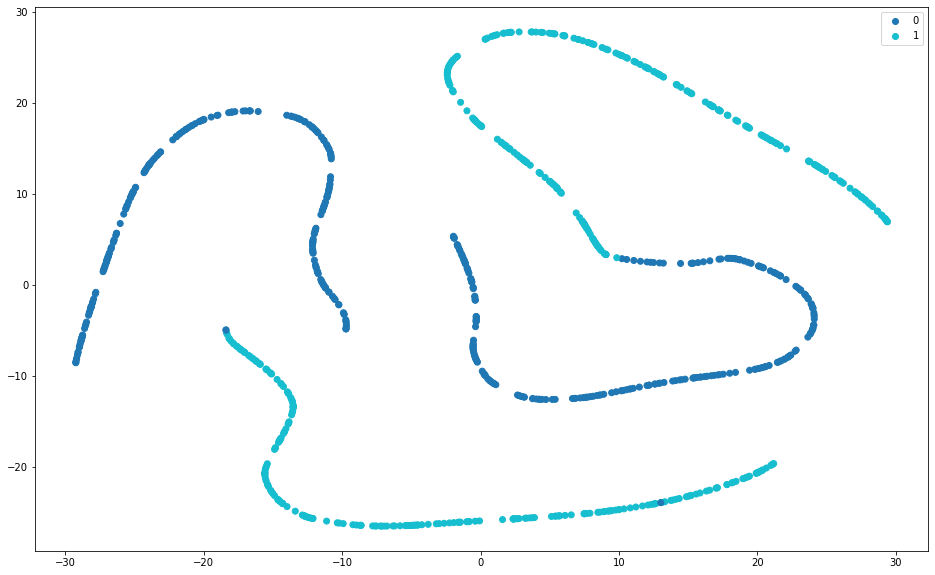

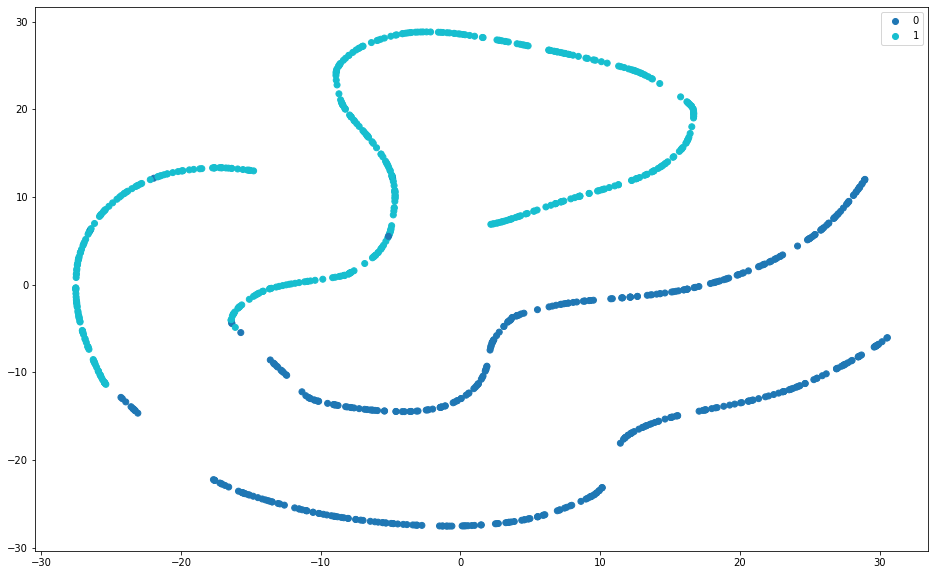

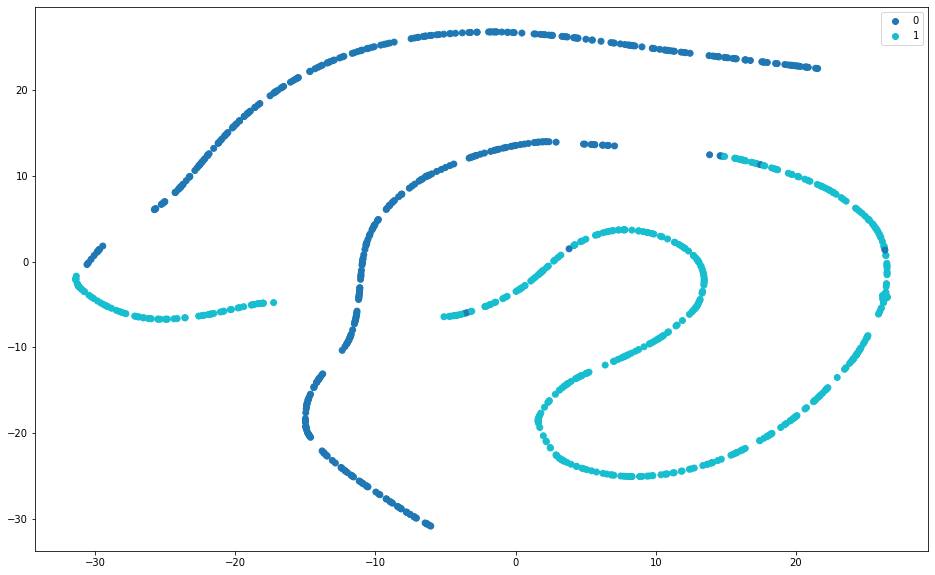

In [ ]:
results_for_k_55 = run_experiment(55, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

In [ ]:
results_for_k_60 = run_experiment(60, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 60 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 0.9999999999999974
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.134567
Epoch: 2/50, Loss: 0.089870
Epoch: 3/50, Loss: 0.076785
Epoch: 4/50, Loss: 0.069928
Epoch: 5/50, Loss: 0.064818
Epoch: 6/50, Loss: 0.059861
Epoch: 7/50, Loss: 0.056807
Epoch: 8/50, Loss: 0.047615
Epoch: 9/50, Loss: 0.047974
Epoch: 10/50, Loss: 0.042008
Epoch: 11/50, Loss: 0.033197
Epoch: 12/50, Loss: 0.029922
Epoch: 13/50, Loss: 0.033346
Epoch: 14/50, Loss: 0.029509
Epoch: 15/50, Loss: 0.031574
Epoch: 16/50, Loss: 0.041952
Epoch: 17/50, Loss: 0.034117
Epoch: 18/50, Loss: 0.027263
Epoch: 19/50, Loss: 0.022004
Epoch: 20/50, Loss: 0.022484
Epoch: 21/50, Loss: 0.022732
Epoch: 22/50, Loss: 0.020

In [ ]:
kmeans_acc = np.zeros((5,12))
kmeans_NMI = np.zeros((5,12))
kmeans_ARI = np.zeros((5,12))
agglo_acc = np.zeros((5,12))
agglo_NMI = np.zeros((5,12))
agglo_ARI = np.zeros((5,12))
kmeans_silhouette = np.zeros((5,12))

for i in range(5):
  
  kmeans_acc[i][0] = results_for_k_5[0][i]
  kmeans_acc[i][1] = results_for_k_10[0][i]
  kmeans_acc[i][2] = results_for_k_15[0][i]
  kmeans_acc[i][3] = results_for_k_20[0][i]
  kmeans_acc[i][4] = results_for_k_25[0][i]
  kmeans_acc[i][5] = results_for_k_30[0][i]
  kmeans_acc[i][6] = results_for_k_35[0][i]
  kmeans_acc[i][7] = results_for_k_40[0][i]
  kmeans_acc[i][8] = results_for_k_45[0][i]
  kmeans_acc[i][9] = results_for_k_50[0][i]
  kmeans_acc[i][10] = results_for_k_55[0][i]
  kmeans_acc[i][11] = results_for_k_60[0][i]

  kmeans_NMI[i][0] = results_for_k_5[1][i]
  kmeans_NMI[i][1] = results_for_k_10[1][i]
  kmeans_NMI[i][2] = results_for_k_15[1][i]
  kmeans_NMI[i][3] = results_for_k_20[1][i]
  kmeans_NMI[i][4] = results_for_k_25[1][i]
  kmeans_NMI[i][5] = results_for_k_30[1][i]
  kmeans_NMI[i][6] = results_for_k_35[1][i]
  kmeans_NMI[i][7] = results_for_k_40[1][i]
  kmeans_NMI[i][8] = results_for_k_45[1][i]
  kmeans_NMI[i][9] = results_for_k_50[1][i]
  kmeans_NMI[i][10] = results_for_k_55[1][i]
  kmeans_NMI[i][11] = results_for_k_60[1][i]

  kmeans_ARI[i][0] = results_for_k_5[2][i]
  kmeans_ARI[i][1] = results_for_k_10[2][i]
  kmeans_ARI[i][2] = results_for_k_15[2][i]
  kmeans_ARI[i][3] = results_for_k_20[2][i]
  kmeans_ARI[i][4] = results_for_k_25[2][i]
  kmeans_ARI[i][5] = results_for_k_30[2][i]
  kmeans_ARI[i][6] = results_for_k_35[2][i]
  kmeans_ARI[i][7] = results_for_k_40[2][i]
  kmeans_ARI[i][8] = results_for_k_45[2][i]
  kmeans_ARI[i][9] = results_for_k_50[2][i]
  kmeans_ARI[i][10] = results_for_k_55[2][i]
  kmeans_ARI[i][11] = results_for_k_60[2][i]

  agglo_acc[i][0] = results_for_k_5[3][i]
  agglo_acc[i][1] = results_for_k_10[3][i]
  agglo_acc[i][2] = results_for_k_15[3][i]
  agglo_acc[i][3] = results_for_k_20[3][i]
  agglo_acc[i][4] = results_for_k_25[3][i]
  agglo_acc[i][5] = results_for_k_30[3][i]
  agglo_acc[i][6] = results_for_k_35[3][i]
  agglo_acc[i][7] = results_for_k_40[3][i]
  agglo_acc[i][8] = results_for_k_45[3][i]
  agglo_acc[i][9] = results_for_k_50[3][i]
  agglo_acc[i][10] = results_for_k_55[3][i]
  agglo_acc[i][11] = results_for_k_60[3][i]

  agglo_NMI[i][0] = results_for_k_5[4][i]
  agglo_NMI[i][1] = results_for_k_10[4][i]
  agglo_NMI[i][2] = results_for_k_15[4][i]
  agglo_NMI[i][3] = results_for_k_20[4][i]
  agglo_NMI[i][4] = results_for_k_25[4][i]
  agglo_NMI[i][5] = results_for_k_30[4][i]
  agglo_NMI[i][6] = results_for_k_35[4][i]
  agglo_NMI[i][7] = results_for_k_40[4][i]
  agglo_NMI[i][8] = results_for_k_45[4][i]
  agglo_NMI[i][9] = results_for_k_50[4][i]
  agglo_NMI[i][10] = results_for_k_55[4][i]
  agglo_NMI[i][11] = results_for_k_60[4][i]

  agglo_ARI[i][0] = results_for_k_5[5][i]
  agglo_ARI[i][1] = results_for_k_10[5][i]
  agglo_ARI[i][2] = results_for_k_15[5][i]
  agglo_ARI[i][3] = results_for_k_20[5][i]
  agglo_ARI[i][4] = results_for_k_25[5][i]
  agglo_ARI[i][5] = results_for_k_30[5][i]
  agglo_ARI[i][6] = results_for_k_35[5][i]
  agglo_ARI[i][7] = results_for_k_40[5][i]
  agglo_ARI[i][8] = results_for_k_45[5][i]
  agglo_ARI[i][9] = results_for_k_50[5][i]
  agglo_ARI[i][10] = results_for_k_55[5][i]
  agglo_ARI[i][11] = results_for_k_60[5][i]

  kmeans_silhouette[i][0] = results_for_k_5[6][i]
  kmeans_silhouette[i][1] = results_for_k_10[6][i]
  kmeans_silhouette[i][2] = results_for_k_15[6][i]
  kmeans_silhouette[i][3] = results_for_k_20[6][i]
  kmeans_silhouette[i][4] = results_for_k_25[6][i]
  kmeans_silhouette[i][5] = results_for_k_30[6][i]
  kmeans_silhouette[i][6] = results_for_k_35[6][i]
  kmeans_silhouette[i][7] = results_for_k_40[6][i]
  kmeans_silhouette[i][8] = results_for_k_45[6][i]
  kmeans_silhouette[i][9] = results_for_k_50[6][i]
  kmeans_silhouette[i][10] = results_for_k_55[6][i]
  kmeans_silhouette[i][11] = results_for_k_60[6][i]


Text(0.5, 0, 'K')

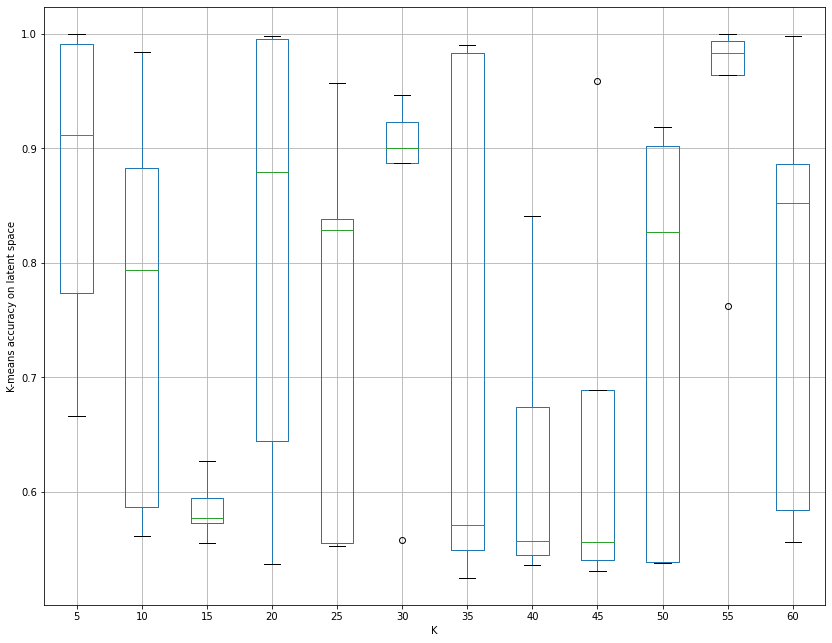

In [ ]:
columns = ['5', '10','15', '20', '25', '30', '35', '40', '45', '50', '55', '60']

df = pd.DataFrame(kmeans_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

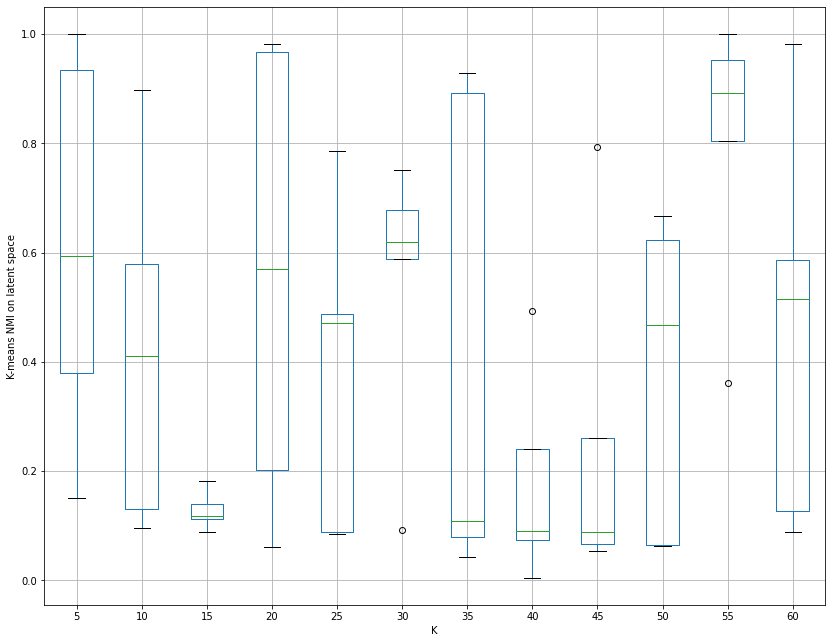

In [ ]:
df = pd.DataFrame(kmeans_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

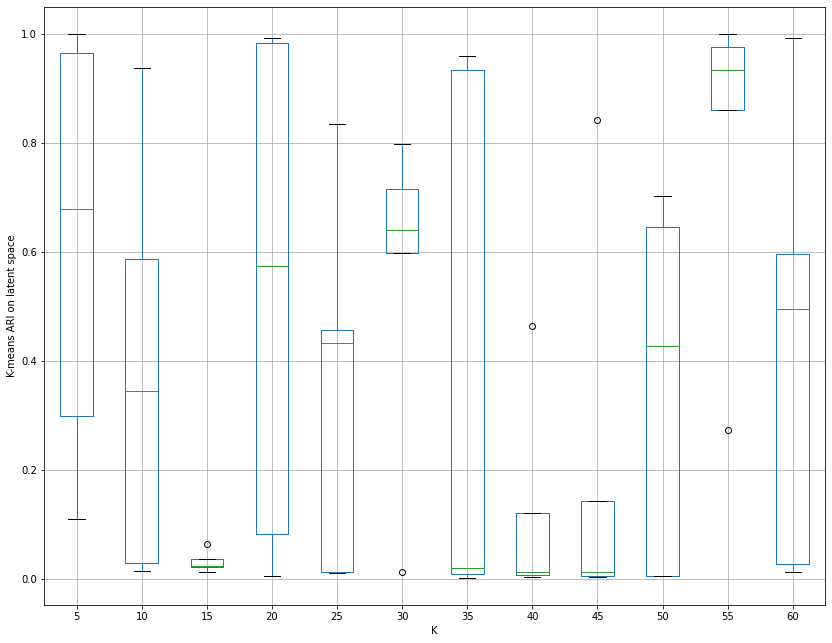

In [ ]:
df = pd.DataFrame(kmeans_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

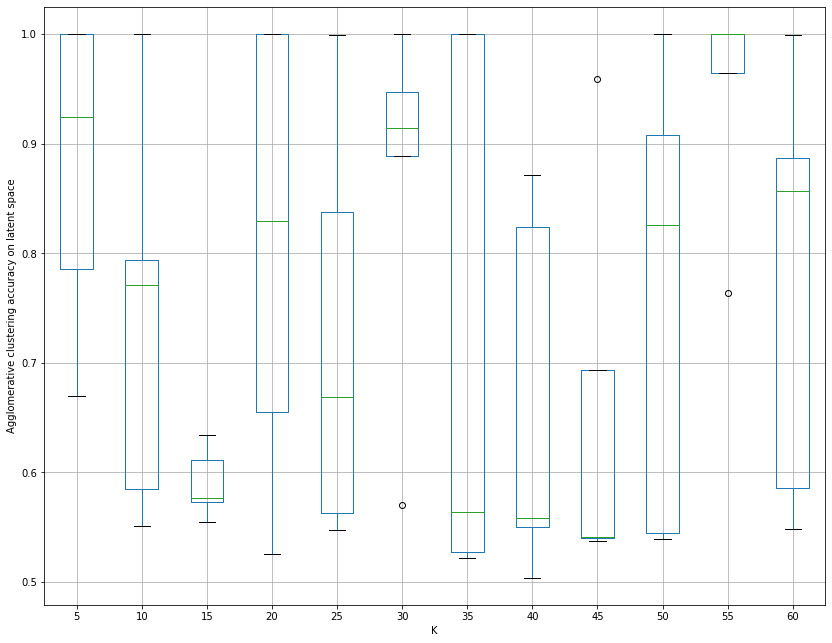

In [ ]:
df = pd.DataFrame(agglo_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

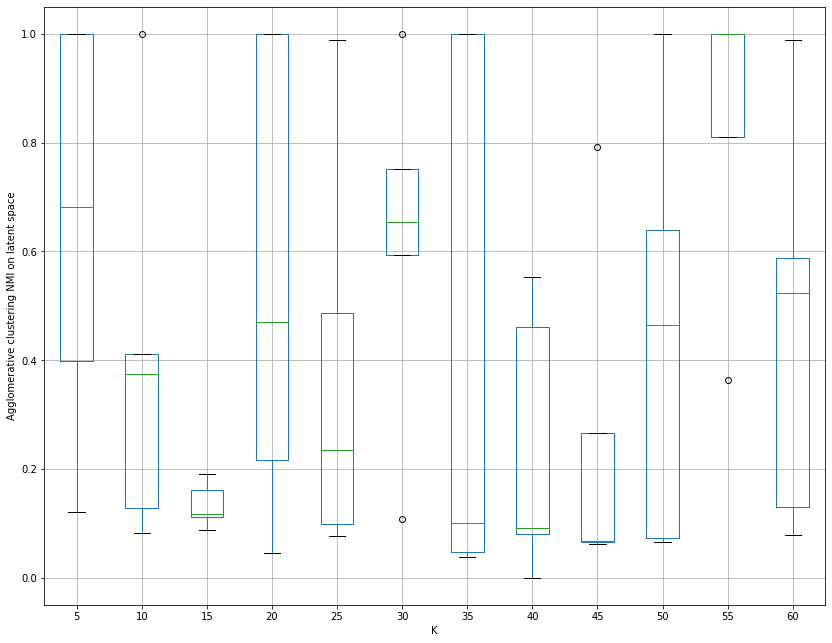

In [ ]:
df = pd.DataFrame(agglo_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

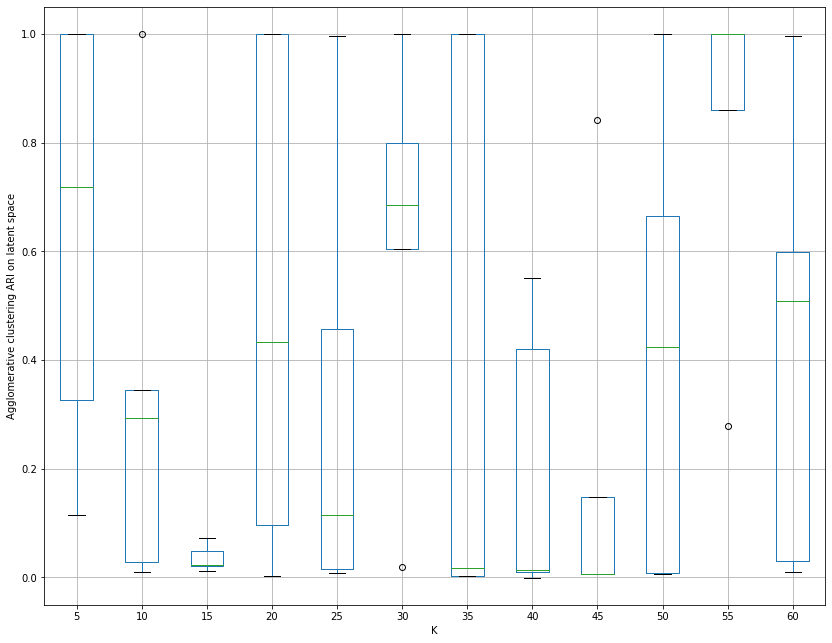

In [ ]:
df = pd.DataFrame(agglo_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

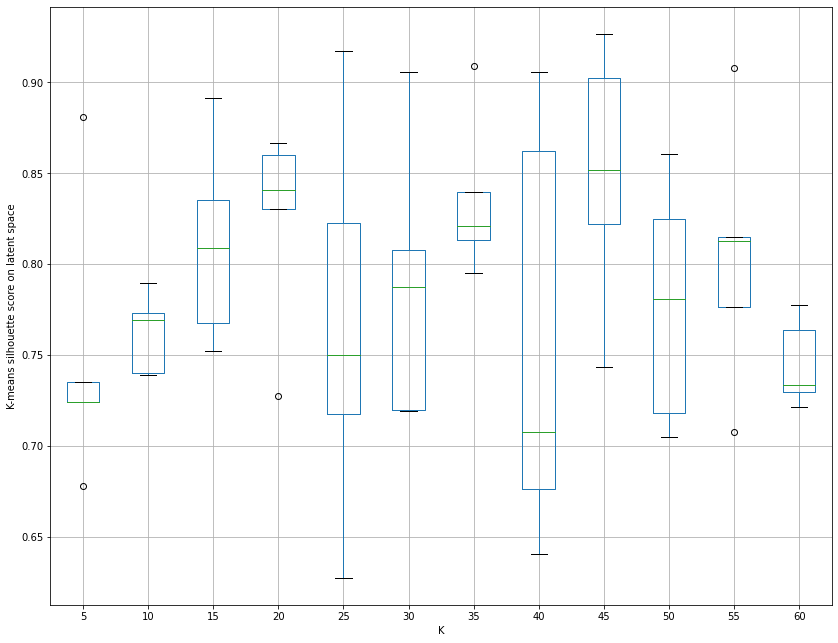

In [ ]:
df = pd.DataFrame(kmeans_silhouette,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means silhouette score on latent space')
boxplot.set_xlabel('K')

# Moons clustering

In [ ]:
kmeans_2_clusters = KMeans(n_clusters=2, n_init=100).fit(moons_datapoints)
retrieved_labels_2_clusters = transform_clusters_to_labels(kmeans_2_clusters.labels_, moons_labels)

print("K_means greedy accuracy score for 2 clusters on initial space:",accuracy_score(moons_labels, retrieved_labels_2_clusters))
print("K_means hungarian accuracy score for 2 clusters on initial space:",cluster_accuracy(moons_labels, kmeans_2_clusters.labels_)[1])
print("K-means normalised mutual info score for 2 clusters on initial space:",normalized_mutual_info_score(moons_labels, kmeans_2_clusters.labels_))
print("K-means ARI for 2 clusters on initial space:",adjusted_rand_score(moons_labels, kmeans_2_clusters.labels_))
print("K-means silhouette score for 2 clusters on initial space:",silhouette_score(moons_datapoints, kmeans_2_clusters.labels_))

K_means greedy accuracy score for 2 clusters on initial space: 0.86
K_means hungarian accuracy score for 2 clusters on initial space: 0.86
K-means normalised mutual info score for 2 clusters on initial space: 0.41582049156429396
K-means ARI for 2 clusters on initial space: 0.5179174657848519
K-means silhouette score for 2 clusters on initial space: 0.5007880991956327


In [ ]:
aggloClustering_2_clusters = AgglomerativeClustering(n_clusters=2).fit(moons_datapoints)
agglo_retrieved_labels = transform_clusters_to_labels(aggloClustering_2_clusters.labels_, moons_labels)

# print the stats on agglomerative clustering

print("Agglomerative clustering on initial space greedy accuracy score:",accuracy_score(moons_labels, agglo_retrieved_labels))
print("Agglomerative clustering on initial space hungarian accuracy score:",cluster_accuracy(moons_labels, aggloClustering_2_clusters.labels_)[1])
print("Normalised mutual info score on agglomerative clustering on initial space:",normalized_mutual_info_score(moons_labels, aggloClustering_2_clusters.labels_))
print("Agglomerative clustering ARI on initial space:",adjusted_rand_score(moons_labels, aggloClustering_2_clusters.labels_))
print("Agglomerative clustering silhouette score for 10 clusters on initial space:",silhouette_score(moons_datapoints, aggloClustering_2_clusters.labels_))

Agglomerative clustering on initial space greedy accuracy score: 0.819
Agglomerative clustering on initial space hungarian accuracy score: 0.819
Normalised mutual info score on agglomerative clustering on initial space: 0.4530314470956316
Agglomerative clustering ARI on initial space: 0.4065277825383417
Agglomerative clustering silhouette score for 10 clusters on initial space: 0.4212145986314873


In [ ]:
data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(moons_datapoints)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.025376
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.442226
[t-SNE] KL divergence after 400 iterations: 0.385832


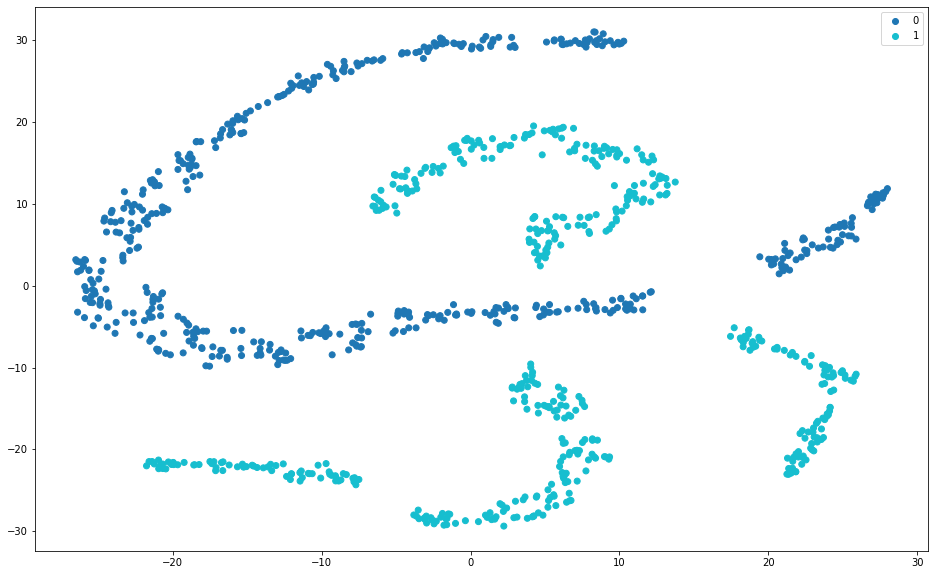

In [ ]:
dataset_labels = [0,1]

plt.figure(figsize=(16,10))
scatterplot = plt.scatter(
    x=data_TSNE[:,0], y=data_TSNE[:,1],
    c=moons_labels,
    cmap="tab10"
)

handles, _ = scatterplot.legend_elements(prop='colors')
plt.legend(handles, dataset_labels)

In [25]:
def run_experiment(K, dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension):

  print('Experiment results for k-means with k =', K, 'clusters:\n')
  print('Running k-means algorithm in order to get our pseudolabels: \n')

  kmeans_initial = KMeans(n_clusters=K, n_init=100).fit(datapoints) 
  cluster_centers = kmeans_initial.cluster_centers_
  cluster_labels = kmeans_initial.labels_
  # real_labels = transform_clusters_to_labels(cluster_labels, labels)

  x_points = [datapoints[i][0] for i in range(len(datapoints))]
  y_points = [datapoints[j][1] for j in range(len(datapoints))]
  colors = ['r','g','b','c','m','y','cyan','yellow','saddlebrown','indigo','navy' ]
  colors_per_cluster = [colors[c] for c in cluster_labels]
  print(colors_per_cluster)

  plt.figure(figsize=(9,7))
  plt.scatter(x=x_points, y=y_points, c=colors_per_cluster)
  # check TSNE representation of our features according to the k categories

  # print("Creating TSNE representation of our features according to the k categories...\n")

  # pseudolabels_indices = [i for i in range(K)]

  # plt.figure(figsize=(16,10)) 
  # kmeans_scatterplot = plt.scatter(
  #     x=data_TSNE[:,0], y=data_TSNE[:,1],
  #     c=cluster_labels,
  #     cmap="gist_rainbow"
  # )

  # handles = kmeans_scatterplot.legend_elements(num=pseudolabels_indices)[0]
  # plt.legend(handles, pseudolabels_indices)

  # savestring = 'pseudolabels_TSNE_initial_space_k=' + str(K) + '.png'
  # plt.savefig(savestring)

  # find out accuracy of the algorithm in the initial space

  kmeans_initial_hungarian_acc = cluster_accuracy(labels, cluster_labels)[1]
  kmeans_initial_NMI = normalized_mutual_info_score(labels, cluster_labels)
  kmeans_initial_ARI = adjusted_rand_score(labels, cluster_labels)

  print("K_means greedy accuracy score (initial space):",accuracy_score(labels, real_labels))
  print("K_means hungarian accuracy score (initial space):",kmeans_initial_hungarian_acc)
  print("Normalised mutual info score (initial space):",kmeans_initial_NMI)
  print("ARI (initial space):",kmeans_initial_ARI, "\n")

  # using the autoencoder model on our data

  print('Using the autoencoder model on our data: \n')

  kmeans_accuracy_scores = []
  k_means_silhouette_scores = []
  k_means_cluster_error_scores = []
  kmeans_NMI_scores = []
  kmeans_ARI_scores = []
  agglo_accuracy_scores = []
  agglo_NMI_scores = []
  agglo_ARI_scores = []
  
  for i in range(5):

    print("ROUND NUMBER ",i + 1,":\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, cluster_centers, cluster_labels, epochs=epochs)
    latent_data = autoencoder.encoder(datapoints, device)

    data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(latent_data)

    dataset_labels = [0,1]

    plt.figure(figsize=(16,10))
    scatterplot = plt.scatter(
        x=data_TSNE[:,0], y=data_TSNE[:,1],
        c=labels,
        cmap="tab10"
    )

    handles, _ = scatterplot.legend_elements(prop='colors')
    plt.legend(handles, dataset_labels)
    
    print("Creating a k-means model on latent data:\n")

    # Maybe we need Standar Scaler

    # std_scaler = StandardScaler()
    # latent_data = std_scaler.fit_transform(latent_data)

    # Clustering on transformed space

    new_kmeans = KMeans(n_clusters=2, n_init=100).fit(latent_data)

    kmeans_clusters = new_kmeans.labels_
    kmeans_cluster_error = new_kmeans.inertia_
    k_means_cluster_error_scores.append(kmeans_cluster_error)
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, labels)

    # print the stats on the transformed space
    kmeans_greedy_acc = accuracy_score(labels, kmeans_greedy_labels)

    # These metrics as input they use the output of the clustering algorithm
    kmeans_hungarian_acc = cluster_accuracy(labels, kmeans_clusters)[1]
    kmeans_NMI = normalized_mutual_info_score(labels, kmeans_clusters)
    kmeans_ARI = adjusted_rand_score(labels, kmeans_clusters)

    kmeans_accuracy_scores.append(kmeans_hungarian_acc)
    kmeans_NMI_scores.append(kmeans_NMI)
    kmeans_ARI_scores.append(kmeans_ARI)

    k_means_silhouette_score = silhouette_score(latent_data, kmeans_clusters)
    k_means_silhouette_scores.append(k_means_silhouette_score)

    print("K-means with 10 clusters on latent space stats: \n")
    print("K-means on latent space greedy accuracy score:",kmeans_greedy_acc)
    print("K-means on latent space hungarian accuracy score:",kmeans_hungarian_acc)
    print("Normalised mutual info score on k-means on latent space:", kmeans_NMI)
    print("ARI score on k-means on latent space:", kmeans_ARI)
    print("K-means cluster error on latent space:", kmeans_cluster_error)
    print("K-means silhouette score on latent space:", k_means_silhouette_score, "\n")

    # do agglomerative clustering on the transformed space

    print("Doing agglomerative clustering on MLP output vectors:\n")
    aggloClustering = AgglomerativeClustering(n_clusters=2).fit(latent_data)
    aggloClustering_clusters = aggloClustering.labels_
    agglo_greedy_labels = transform_clusters_to_labels(aggloClustering_clusters, labels)

    # print the stats on agglomerative clustering
    agglo_greedy_acc = accuracy_score(labels, agglo_greedy_labels)
    agglo_hungarian_acc = cluster_accuracy(labels, aggloClustering_clusters)[1]
    agglo_NMI = normalized_mutual_info_score(labels, aggloClustering_clusters)
    agglo_ARI = adjusted_rand_score(labels, aggloClustering_clusters)

    agglo_accuracy_scores.append(agglo_greedy_acc)
    agglo_NMI_scores.append(agglo_NMI)
    agglo_ARI_scores.append(agglo_ARI)

    print("Agglomerative clustering on latent space greedy accuracy score:", agglo_greedy_acc)
    print("Agglomerative clustering on latent space hungarian accuracy score:", agglo_hungarian_acc)
    print("Normalised mutual info score on agglomerative clustering on latent space:",agglo_NMI, "\n")
    print("ARI score on agglomerative clustering on latent space:", agglo_ARI, "\n")

  print("Average k-means accuracy score at latent space:", sum(kmeans_accuracy_scores) / len(kmeans_accuracy_scores), "\n")
  print("Average k-means NMI score at latent space:", sum(kmeans_NMI_scores) / len(kmeans_NMI_scores), "\n")
  print("Average k-means ARI score at latent space:", sum(kmeans_ARI_scores) / len(kmeans_ARI_scores), "\n")
  print("Average agglomerative clustering accuracy score at latent space:", sum(agglo_accuracy_scores) / len(agglo_accuracy_scores), "\n")
  print("Average agglomerative clustering NMI score at latent space:", sum(agglo_NMI_scores) / len(agglo_NMI_scores), "\n")
  print("Average agglomerative clustering ARI score at latent space:", sum(agglo_ARI_scores) / len(agglo_ARI_scores), "\n")
  print("Average k-means silhouette score on latent space:", sum(k_means_silhouette_scores) / len(k_means_silhouette_scores), "\n")
  print("Average k-means cluster error on latent space:", sum(k_means_cluster_error_scores) / len(k_means_cluster_error_scores), "\n")

  return [ kmeans_accuracy_scores, kmeans_NMI_scores, kmeans_ARI_scores, agglo_accuracy_scores, agglo_NMI_scores, agglo_ARI_scores, k_means_silhouette_scores]

In [ ]:
results_for_k_5 = run_experiment(5, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 5 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.886
K_means hungarian accuracy score (initial space): 0.886
Normalised mutual info score (initial space): 0.5859996599226486
ARI (initial space): 0.5956002387947761 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.028258
Epoch: 2/50, Loss: 0.017755
Epoch: 3/50, Loss: 0.016792
Epoch: 4/50, Loss: 0.016080
Epoch: 5/50, Loss: 0.015432
Epoch: 6/50, Loss: 0.014902
Epoch: 7/50, Loss: 0.014234
Epoch: 8/50, Loss: 0.013668
Epoch: 9/50, Loss: 0.013146
Epoch: 10/50, Loss: 0.012564
Epoch: 11/50, Loss: 0.012000
Epoch: 12/50, Loss: 0.011496
Epoch: 13/50, Loss: 0.011010
Epoch: 14/50, Loss: 0.010494
Epoch: 15/50, Loss: 0.010005
Epoch: 16/50, Loss: 0.009552
Epoch: 17/50, Loss: 0.009065
Epoch: 18/50, Loss: 0.008616
Epoch: 19/50, Loss: 0.008196
Epoch: 20/50, Loss: 0.007736
Epoch: 21/50, Loss: 0.007388
Epoch: 

Experiment results for k-means with k = 10 clusters:

Running k-means algorithm in order to get our pseudolabels: 

['c', 'indigo', 'r', 'y', 'b', 'c', 'g', 'yellow', 'r', 'b', 'saddlebrown', 'y', 'indigo', 'yellow', 'm', 'g', 'c', 'cyan', 'g', 'cyan', 'g', 'saddlebrown', 'r', 'r', 'indigo', 'indigo', 'g', 'cyan', 'b', 'g', 'indigo', 'b', 'm', 'b', 'r', 'b', 'c', 'r', 'c', 'yellow', 'yellow', 'c', 'm', 'b', 'yellow', 'indigo', 'indigo', 'cyan', 'r', 'm', 'r', 'yellow', 'yellow', 'saddlebrown', 'indigo', 'm', 'yellow', 'yellow', 'c', 'r', 'y', 'm', 'cyan', 'yellow', 'saddlebrown', 'yellow', 'yellow', 'y', 'yellow', 'y', 'b', 'yellow', 'b', 'yellow', 'c', 'saddlebrown', 'r', 'indigo', 'm', 'b', 'yellow', 'saddlebrown', 'r', 'c', 'c', 'b', 'yellow', 'y', 'saddlebrown', 'indigo', 'saddlebrown', 'saddlebrown', 'c', 'yellow', 'm', 'saddlebrown', 'm', 'cyan', 'r', 'm', 'indigo', 'indigo', 'g', 'indigo', 'r', 'm', 'b', 'indigo', 'c', 'yellow', 'cyan', 'm', 'saddlebrown', 'y', 'yellow', 'r', 'y

NameError: ignored

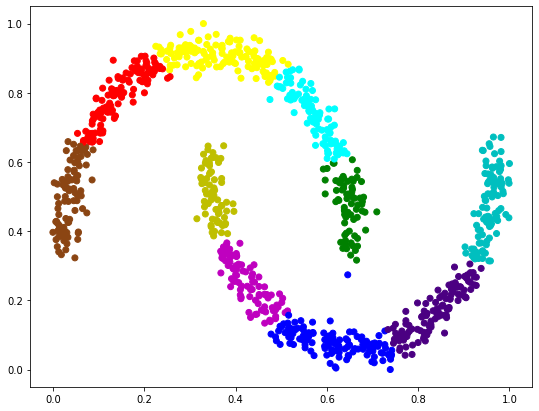

In [26]:
results_for_k_10 = run_experiment(10, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

In [ ]:
results_for_k_15 = run_experiment(15, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 15 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.023466
Epoch: 2/50, Loss: 0.016731
Epoch: 3/50, Loss: 0.015536
Epoch: 4/50, Loss: 0.014902
Epoch: 5/50, Loss: 0.013835
Epoch: 6/50, Loss: 0.012087
Epoch: 7/50, Loss: 0.007393
Epoch: 8/50, Loss: 0.005278
Epoch: 9/50, Loss: 0.004592
Epoch: 10/50, Loss: 0.005818
Epoch: 11/50, Loss: 0.004515
Epoch: 12/50, Loss: 0.004117
Epoch: 13/50, Loss: 0.003453
Epoch: 14/50, Loss: 0.003242
Epoch: 15/50, Loss: 0.003126
Epoch: 16/50, Loss: 0.002973
Epoch: 17/50, Loss: 0.002816
Epoch: 18/50, Loss: 0.002637
Epoch: 19/50, Loss: 0.002500
Epoch: 20/50, Loss: 0.002378
Epoch: 21/50, Loss: 0.002242
Epoch: 22/50, Loss: 0.002129
Epoch: 23/5

In [ ]:
results_for_k_20 = run_experiment(20, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 20 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.078458
Epoch: 2/50, Loss: 0.054228
Epoch: 3/50, Loss: 0.040045
Epoch: 4/50, Loss: 0.031349
Epoch: 5/50, Loss: 0.029218
Epoch: 6/50, Loss: 0.028676
Epoch: 7/50, Loss: 0.027367
Epoch: 8/50, Loss: 0.026440
Epoch: 9/50, Loss: 0.025149
Epoch: 10/50, Loss: 0.023727
Epoch: 11/50, Loss: 0.021082
Epoch: 12/50, Loss: 0.017511
Epoch: 13/50, Loss: 0.016385
Epoch: 14/50, Loss: 0.012483
Epoch: 15/50, Loss: 0.010595
Epoch: 16/50, Loss: 0.009423
Epoch: 17/50, Loss: 0.008844
Epoch: 18/50, Loss: 0.008398
Epoch: 19/50, Loss: 0.008082
Epoch: 20/50, Loss: 0.007824
Epoch: 21/50, Loss: 0.007616
Epoch: 22/50, Loss: 0.007183
Epoch: 23/5

In [ ]:
results_for_k_25 = run_experiment(25, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 25 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.013264
Epoch: 2/50, Loss: 0.007698
Epoch: 3/50, Loss: 0.006668
Epoch: 4/50, Loss: 0.006348
Epoch: 5/50, Loss: 0.006012
Epoch: 6/50, Loss: 0.005734
Epoch: 7/50, Loss: 0.005475
Epoch: 8/50, Loss: 0.005219
Epoch: 9/50, Loss: 0.004983
Epoch: 10/50, Loss: 0.004752
Epoch: 11/50, Loss: 0.004527
Epoch: 12/50, Loss: 0.004301
Epoch: 13/50, Loss: 0.004071
Epoch: 14/50, Loss: 0.003812
Epoch: 15/50, Loss: 0.003477
Epoch: 16/50, Loss: 0.002877
Epoch: 17/50, Loss: 0.001922
Epoch: 18/50, Loss: 0.001165
Epoch: 19/50, Loss: 0.000915
Epoch: 20/50, Loss: 0.000758
Epoch: 21/50, Loss: 0.000727
Epoch: 22/50, Loss: 0.000656
Epoch: 23/5

In [ ]:
results_for_k_30 = run_experiment(30, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 30 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.068783
Epoch: 2/50, Loss: 0.050881
Epoch: 3/50, Loss: 0.046416
Epoch: 4/50, Loss: 0.042013
Epoch: 5/50, Loss: 0.038312
Epoch: 6/50, Loss: 0.037328
Epoch: 7/50, Loss: 0.034890
Epoch: 8/50, Loss: 0.033281
Epoch: 9/50, Loss: 0.032297
Epoch: 10/50, Loss: 0.031196
Epoch: 11/50, Loss: 0.030172
Epoch: 12/50, Loss: 0.029515
Epoch: 13/50, Loss: 0.028725
Epoch: 14/50, Loss: 0.027837
Epoch: 15/50, Loss: 0.027097
Epoch: 16/50, Loss: 0.026471
Epoch: 17/50, Loss: 0.025845
Epoch: 18/50, Loss: 0.025192
Epoch: 19/50, Loss: 0.024570
Epoch: 20/50, Loss: 0.023931
Epoch: 21/50, Loss: 0.023346
Epoch: 22/50, Loss: 0.022761
Epoch: 23/5

In [ ]:
results_for_k_35 = run_experiment(35, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 35 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.018865
Epoch: 2/50, Loss: 0.017258
Epoch: 3/50, Loss: 0.016157
Epoch: 4/50, Loss: 0.014664
Epoch: 5/50, Loss: 0.012895
Epoch: 6/50, Loss: 0.011457
Epoch: 7/50, Loss: 0.009679
Epoch: 8/50, Loss: 0.008579
Epoch: 9/50, Loss: 0.008005
Epoch: 10/50, Loss: 0.007481
Epoch: 11/50, Loss: 0.007060
Epoch: 12/50, Loss: 0.006623
Epoch: 13/50, Loss: 0.006259
Epoch: 14/50, Loss: 0.005879
Epoch: 15/50, Loss: 0.005710
Epoch: 16/50, Loss: 0.005308
Epoch: 17/50, Loss: 0.004841
Epoch: 18/50, Loss: 0.004522
Epoch: 19/50, Loss: 0.004204
Epoch: 20/50, Loss: 0.003929
Epoch: 21/50, Loss: 0.003653
Epoch: 22/50, Loss: 0.003394
Epoch: 23/5

Experiment results for k-means with k = 40 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.032949
Epoch: 2/50, Loss: 0.020761
Epoch: 3/50, Loss: 0.015647
Epoch: 4/50, Loss: 0.013934
Epoch: 5/50, Loss: 0.012080
Epoch: 6/50, Loss: 0.010174
Epoch: 7/50, Loss: 0.009308
Epoch: 8/50, Loss: 0.008834
Epoch: 9/50, Loss: 0.008670
Epoch: 10/50, Loss: 0.008617
Epoch: 11/50, Loss: 0.008431
Epoch: 12/50, Loss: 0.008518
Epoch: 13/50, Loss: 0.006798
Epoch: 14/50, Loss: 0.006593
Epoch: 15/50, Loss: 0.006506
Epoch: 16/50, Loss: 0.006175
Epoch: 17/50, Loss: 0.005828
Epoch: 18/50, Loss: 0.005575
Epoch: 19/50, Loss: 0.005379
Epoch: 20/50, Loss: 0.005174
Epoch: 21/50, Loss: 0.004935
Epoch: 22/50, Loss: 0.004784
Epoch: 23/5

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.915596
[t-SNE] KL divergence after 400 iterations: 0.265154
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 1.0
K-means on latent space hungarian accuracy score: 1.0
Normalised mutual info score on k-means on latent space: 1.0
ARI score on k-means on latent space: 1.0
K-means cluster error on latent space: 42.93867111206055
K-means silhouette score on latent space: 0.88917136 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 1.0
Agglomerative clustering on latent space hungarian accuracy score: 1.0
Normalised mutual info score on agglomerative clustering on latent space: 1.0 

ARI score on agglomerative clustering on latent space: 1.0 

ROUND NUMBER  2 :

Epoch: 1/50, Loss: 0.027650
Epoch: 2/50, Loss: 0.022906
Epoch: 3/50, Loss: 0.017801
Epoch: 4/50, Loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.797272
[t-SNE] KL divergence after 400 iterations: 0.269214
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 1.0
K-means on latent space hungarian accuracy score: 1.0
Normalised mutual info score on k-means on latent space: 1.0
ARI score on k-means on latent space: 1.0
K-means cluster error on latent space: 29.32563591003418
K-means silhouette score on latent space: 0.90380466 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 1.0
Agglomerative clustering on latent space hungarian accuracy score: 1.0
Normalised mutual info score on agglomerative clustering on latent space: 1.0 

ARI score on agglomerative clustering on latent space: 1.0 

ROUND NUMBER  3 :

Epoch: 1/50, Loss: 0.032587
Epoch: 2/50, Loss: 0.026533
Epoch: 3/50, Loss: 0.025354
Epoch: 4/50, Loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.664921
[t-SNE] KL divergence after 400 iterations: 0.262800
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 1.0
K-means on latent space hungarian accuracy score: 1.0
Normalised mutual info score on k-means on latent space: 1.0
ARI score on k-means on latent space: 1.0
K-means cluster error on latent space: 44.81028747558594
K-means silhouette score on latent space: 0.8864553 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 1.0
Agglomerative clustering on latent space hungarian accuracy score: 1.0
Normalised mutual info score on agglomerative clustering on latent space: 1.0 

ARI score on agglomerative clustering on latent space: 1.0 

ROUND NUMBER  4 :

Epoch: 1/50, Loss: 0.033667
Epoch: 2/50, Loss: 0.026055
Epoch: 3/50, Loss: 0.025596
Epoch: 4/50, Loss: 0

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.263332
[t-SNE] KL divergence after 400 iterations: 0.268789
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 1.0
K-means on latent space hungarian accuracy score: 1.0
Normalised mutual info score on k-means on latent space: 1.0
ARI score on k-means on latent space: 1.0
K-means cluster error on latent space: 76.26542663574219
K-means silhouette score on latent space: 0.8452119 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 1.0
Agglomerative clustering on latent space hungarian accuracy score: 1.0
Normalised mutual info score on agglomerative clustering on latent space: 1.0 

ARI score on agglomerative clustering on latent space: 1.0 

ROUND NUMBER  5 :

Epoch: 1/50, Loss: 0.029907
Epoch: 2/50, Loss: 0.024129
Epoch: 3/50, Loss: 0.022880
Epoch: 4/50, Loss: 0

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.815308
[t-SNE] KL divergence after 400 iterations: 0.266610
Creating a k-means model on latent data:

K-means with 10 clusters on latent space stats: 

K-means on latent space greedy accuracy score: 1.0
K-means on latent space hungarian accuracy score: 1.0
Normalised mutual info score on k-means on latent space: 1.0
ARI score on k-means on latent space: 1.0
K-means cluster error on latent space: 46.04995346069336
K-means silhouette score on latent space: 0.8862713 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on latent space greedy accuracy score: 1.0
Agglomerative clustering on latent space hungarian accuracy score: 1.0
Normalised mutual info score on agglomerative clustering on latent space: 1.0 

ARI score on agglomerative clustering on latent space: 1.0 

Average k-means accuracy score at latent space: 1.0 

Average k-means NMI score at latent space: 1.0 

Average k-means ARI 

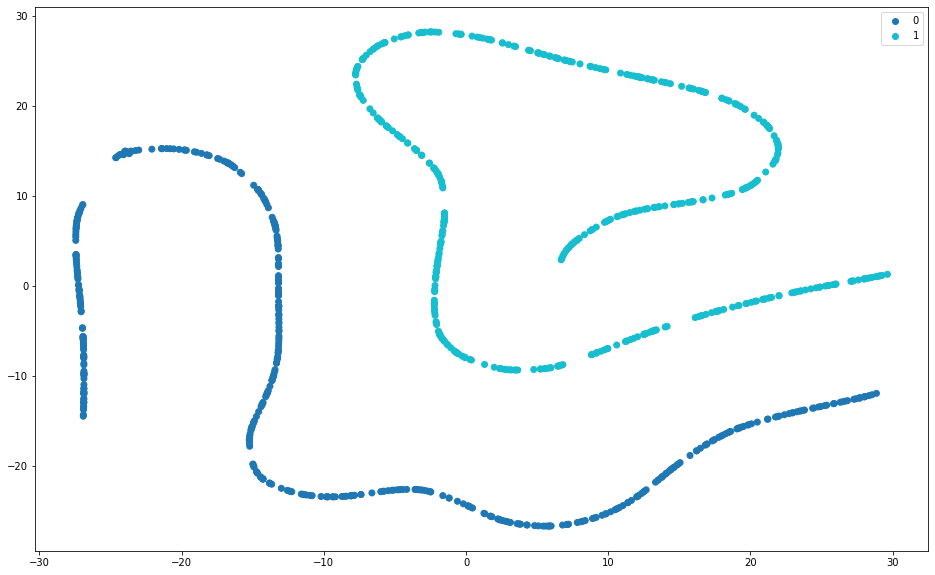

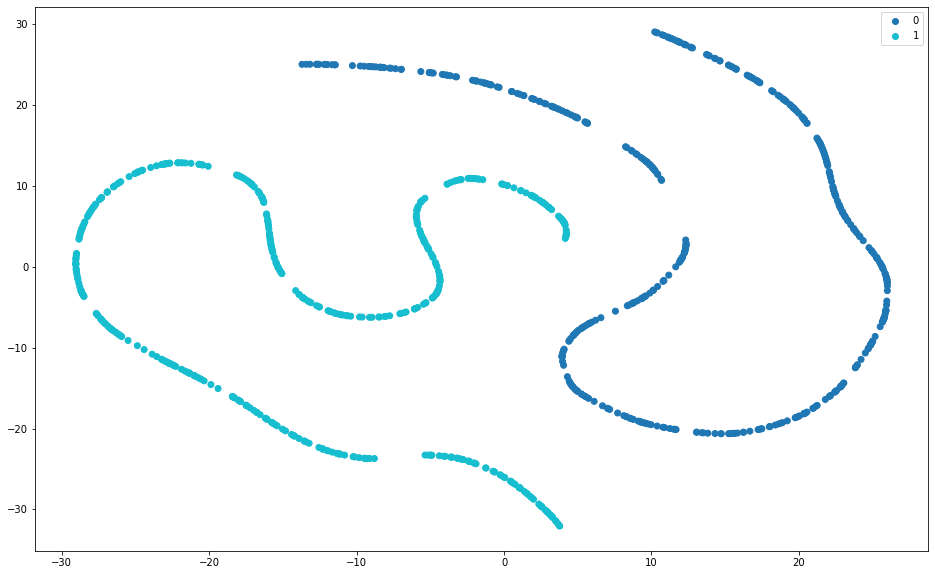

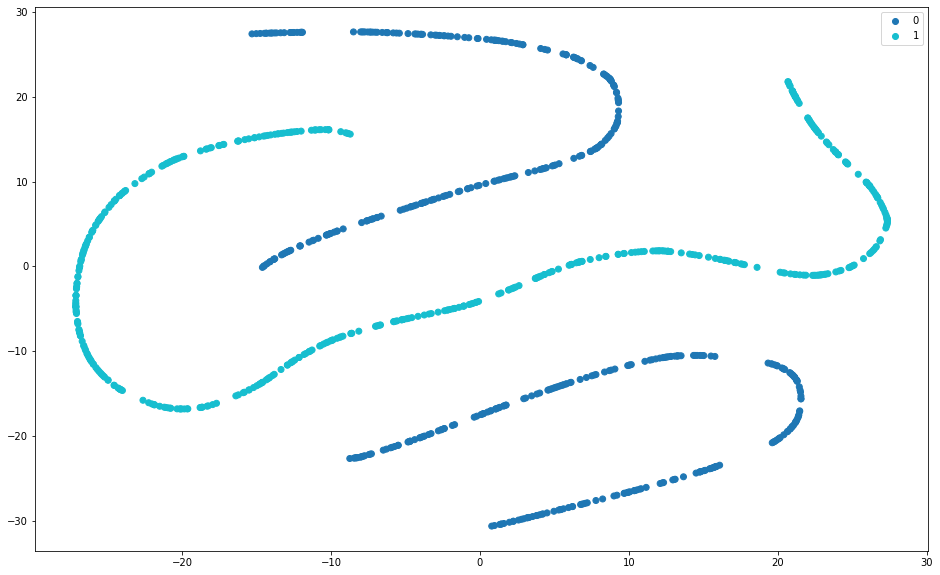

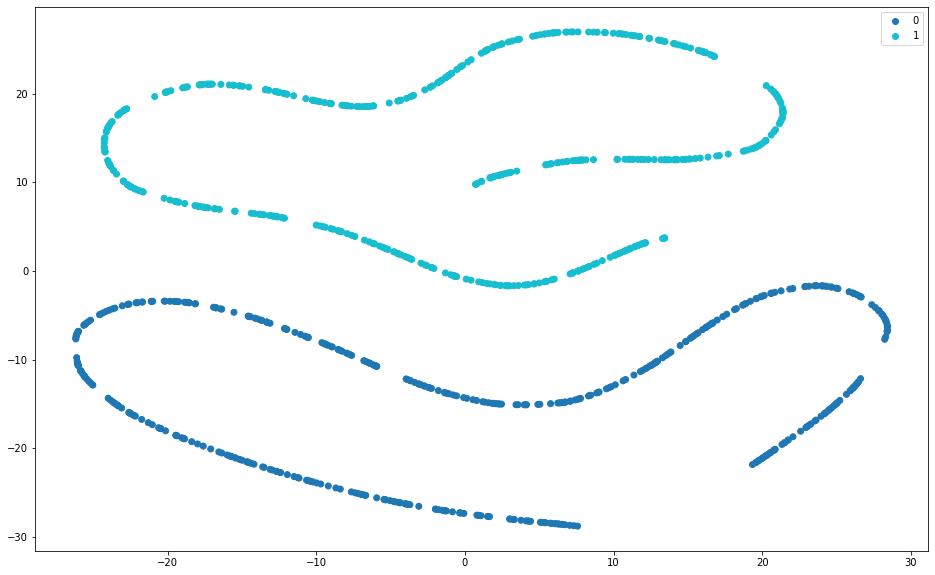

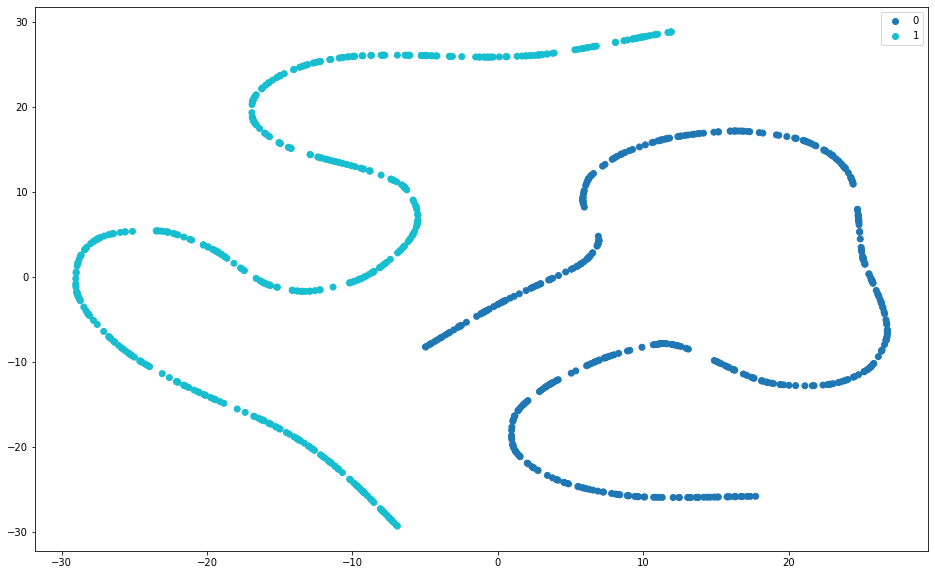

In [ ]:
results_for_k_40 = run_experiment(40, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

In [ ]:
results_for_k_45 = run_experiment(45, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 45 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.113621
Epoch: 2/50, Loss: 0.073169
Epoch: 3/50, Loss: 0.052872
Epoch: 4/50, Loss: 0.048883
Epoch: 5/50, Loss: 0.047518
Epoch: 6/50, Loss: 0.045568
Epoch: 7/50, Loss: 0.043504
Epoch: 8/50, Loss: 0.040725
Epoch: 9/50, Loss: 0.034969
Epoch: 10/50, Loss: 0.026078
Epoch: 11/50, Loss: 0.021179
Epoch: 12/50, Loss: 0.018392
Epoch: 13/50, Loss: 0.015718
Epoch: 14/50, Loss: 0.015140
Epoch: 15/50, Loss: 0.014669
Epoch: 16/50, Loss: 0.013897
Epoch: 17/50, Loss: 0.013255
Epoch: 18/50, Loss: 0.012740
Epoch: 19/50, Loss: 0.012291
Epoch: 20/50, Loss: 0.011764
Epoch: 21/50, Loss: 0.011289
Epoch: 22/50, Loss: 0.011073
Epoch: 23/5

In [ ]:
results_for_k_50 = run_experiment(50, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 50 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.048773
Epoch: 2/50, Loss: 0.036479
Epoch: 3/50, Loss: 0.034898
Epoch: 4/50, Loss: 0.033957
Epoch: 5/50, Loss: 0.033006
Epoch: 6/50, Loss: 0.032049
Epoch: 7/50, Loss: 0.031140
Epoch: 8/50, Loss: 0.030232
Epoch: 9/50, Loss: 0.029271
Epoch: 10/50, Loss: 0.028178
Epoch: 11/50, Loss: 0.026829
Epoch: 12/50, Loss: 0.024291
Epoch: 13/50, Loss: 0.020753
Epoch: 14/50, Loss: 0.017414
Epoch: 15/50, Loss: 0.015318
Epoch: 16/50, Loss: 0.014644
Epoch: 17/50, Loss: 0.013848
Epoch: 18/50, Loss: 0.013143
Epoch: 19/50, Loss: 0.012495
Epoch: 20/50, Loss: 0.011886
Epoch: 21/50, Loss: 0.011213
Epoch: 22/50, Loss: 0.010784
Epoch: 23/5

In [ ]:
results_for_k_55 = run_experiment(55, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 55 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.039823
Epoch: 2/50, Loss: 0.026667
Epoch: 3/50, Loss: 0.025002
Epoch: 4/50, Loss: 0.023497
Epoch: 5/50, Loss: 0.020665
Epoch: 6/50, Loss: 0.017015
Epoch: 7/50, Loss: 0.014071
Epoch: 8/50, Loss: 0.012755
Epoch: 9/50, Loss: 0.009807
Epoch: 10/50, Loss: 0.008729
Epoch: 11/50, Loss: 0.007951
Epoch: 12/50, Loss: 0.007632
Epoch: 13/50, Loss: 0.007382
Epoch: 14/50, Loss: 0.006977
Epoch: 15/50, Loss: 0.006526
Epoch: 16/50, Loss: 0.006287
Epoch: 17/50, Loss: 0.005910
Epoch: 18/50, Loss: 0.005641
Epoch: 19/50, Loss: 0.005424
Epoch: 20/50, Loss: 0.005118
Epoch: 21/50, Loss: 0.004869
Epoch: 22/50, Loss: 0.004649
Epoch: 23/5

In [ ]:
results_for_k_60 = run_experiment(60, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 60 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.057799
Epoch: 2/50, Loss: 0.038317
Epoch: 3/50, Loss: 0.036373
Epoch: 4/50, Loss: 0.033709
Epoch: 5/50, Loss: 0.028286
Epoch: 6/50, Loss: 0.019299
Epoch: 7/50, Loss: 0.014991
Epoch: 8/50, Loss: 0.011899
Epoch: 9/50, Loss: 0.010758
Epoch: 10/50, Loss: 0.010628
Epoch: 11/50, Loss: 0.010162
Epoch: 12/50, Loss: 0.009788
Epoch: 13/50, Loss: 0.008747
Epoch: 14/50, Loss: 0.008361
Epoch: 15/50, Loss: 0.008101
Epoch: 16/50, Loss: 0.007662
Epoch: 17/50, Loss: 0.007366
Epoch: 18/50, Loss: 0.007076
Epoch: 19/50, Loss: 0.006704
Epoch: 20/50, Loss: 0.006533
Epoch: 21/50, Loss: 0.006359
Epoch: 22/50, Loss: 0.006269
Epoch: 23/5

In [ ]:
kmeans_acc = np.zeros((5,12))
kmeans_NMI = np.zeros((5,12))
kmeans_ARI = np.zeros((5,12))
agglo_acc = np.zeros((5,12))
agglo_NMI = np.zeros((5,12))
agglo_ARI = np.zeros((5,12))
kmeans_silhouette = np.zeros((5,12))

for i in range(5):
  
  kmeans_acc[i][0] = results_for_k_5[0][i]
  kmeans_acc[i][1] = results_for_k_10[0][i]
  kmeans_acc[i][2] = results_for_k_15[0][i]
  kmeans_acc[i][3] = results_for_k_20[0][i]
  kmeans_acc[i][4] = results_for_k_25[0][i]
  kmeans_acc[i][5] = results_for_k_30[0][i]
  kmeans_acc[i][6] = results_for_k_35[0][i]
  kmeans_acc[i][7] = results_for_k_40[0][i]
  kmeans_acc[i][8] = results_for_k_45[0][i]
  kmeans_acc[i][9] = results_for_k_50[0][i]
  kmeans_acc[i][10] = results_for_k_55[0][i]
  kmeans_acc[i][11] = results_for_k_60[0][i]

  kmeans_NMI[i][0] = results_for_k_5[1][i]
  kmeans_NMI[i][1] = results_for_k_10[1][i]
  kmeans_NMI[i][2] = results_for_k_15[1][i]
  kmeans_NMI[i][3] = results_for_k_20[1][i]
  kmeans_NMI[i][4] = results_for_k_25[1][i]
  kmeans_NMI[i][5] = results_for_k_30[1][i]
  kmeans_NMI[i][6] = results_for_k_35[1][i]
  kmeans_NMI[i][7] = results_for_k_40[1][i]
  kmeans_NMI[i][8] = results_for_k_45[1][i]
  kmeans_NMI[i][9] = results_for_k_50[1][i]
  kmeans_NMI[i][10] = results_for_k_55[1][i]
  kmeans_NMI[i][11] = results_for_k_60[1][i]

  kmeans_ARI[i][0] = results_for_k_5[2][i]
  kmeans_ARI[i][1] = results_for_k_10[2][i]
  kmeans_ARI[i][2] = results_for_k_15[2][i]
  kmeans_ARI[i][3] = results_for_k_20[2][i]
  kmeans_ARI[i][4] = results_for_k_25[2][i]
  kmeans_ARI[i][5] = results_for_k_30[2][i]
  kmeans_ARI[i][6] = results_for_k_35[2][i]
  kmeans_ARI[i][7] = results_for_k_40[2][i]
  kmeans_ARI[i][8] = results_for_k_45[2][i]
  kmeans_ARI[i][9] = results_for_k_50[2][i]
  kmeans_ARI[i][10] = results_for_k_55[2][i]
  kmeans_ARI[i][11] = results_for_k_60[2][i]

  agglo_acc[i][0] = results_for_k_5[3][i]
  agglo_acc[i][1] = results_for_k_10[3][i]
  agglo_acc[i][2] = results_for_k_15[3][i]
  agglo_acc[i][3] = results_for_k_20[3][i]
  agglo_acc[i][4] = results_for_k_25[3][i]
  agglo_acc[i][5] = results_for_k_30[3][i]
  agglo_acc[i][6] = results_for_k_35[3][i]
  agglo_acc[i][7] = results_for_k_40[3][i]
  agglo_acc[i][8] = results_for_k_45[3][i]
  agglo_acc[i][9] = results_for_k_50[3][i]
  agglo_acc[i][10] = results_for_k_55[3][i]
  agglo_acc[i][11] = results_for_k_60[3][i]

  agglo_NMI[i][0] = results_for_k_5[4][i]
  agglo_NMI[i][1] = results_for_k_10[4][i]
  agglo_NMI[i][2] = results_for_k_15[4][i]
  agglo_NMI[i][3] = results_for_k_20[4][i]
  agglo_NMI[i][4] = results_for_k_25[4][i]
  agglo_NMI[i][5] = results_for_k_30[4][i]
  agglo_NMI[i][6] = results_for_k_35[4][i]
  agglo_NMI[i][7] = results_for_k_40[4][i]
  agglo_NMI[i][8] = results_for_k_45[4][i]
  agglo_NMI[i][9] = results_for_k_50[4][i]
  agglo_NMI[i][10] = results_for_k_55[4][i]
  agglo_NMI[i][11] = results_for_k_60[4][i]

  agglo_ARI[i][0] = results_for_k_5[5][i]
  agglo_ARI[i][1] = results_for_k_10[5][i]
  agglo_ARI[i][2] = results_for_k_15[5][i]
  agglo_ARI[i][3] = results_for_k_20[5][i]
  agglo_ARI[i][4] = results_for_k_25[5][i]
  agglo_ARI[i][5] = results_for_k_30[5][i]
  agglo_ARI[i][6] = results_for_k_35[5][i]
  agglo_ARI[i][7] = results_for_k_40[5][i]
  agglo_ARI[i][8] = results_for_k_45[5][i]
  agglo_ARI[i][9] = results_for_k_50[5][i]
  agglo_ARI[i][10] = results_for_k_55[5][i]
  agglo_ARI[i][11] = results_for_k_60[5][i]

  kmeans_silhouette[i][0] = results_for_k_5[6][i]
  kmeans_silhouette[i][1] = results_for_k_10[6][i]
  kmeans_silhouette[i][2] = results_for_k_15[6][i]
  kmeans_silhouette[i][3] = results_for_k_20[6][i]
  kmeans_silhouette[i][4] = results_for_k_25[6][i]
  kmeans_silhouette[i][5] = results_for_k_30[6][i]
  kmeans_silhouette[i][6] = results_for_k_35[6][i]
  kmeans_silhouette[i][7] = results_for_k_40[6][i]
  kmeans_silhouette[i][8] = results_for_k_45[6][i]
  kmeans_silhouette[i][9] = results_for_k_50[6][i]
  kmeans_silhouette[i][10] = results_for_k_55[6][i]
  kmeans_silhouette[i][11] = results_for_k_60[6][i]


Text(0.5, 0, 'K')

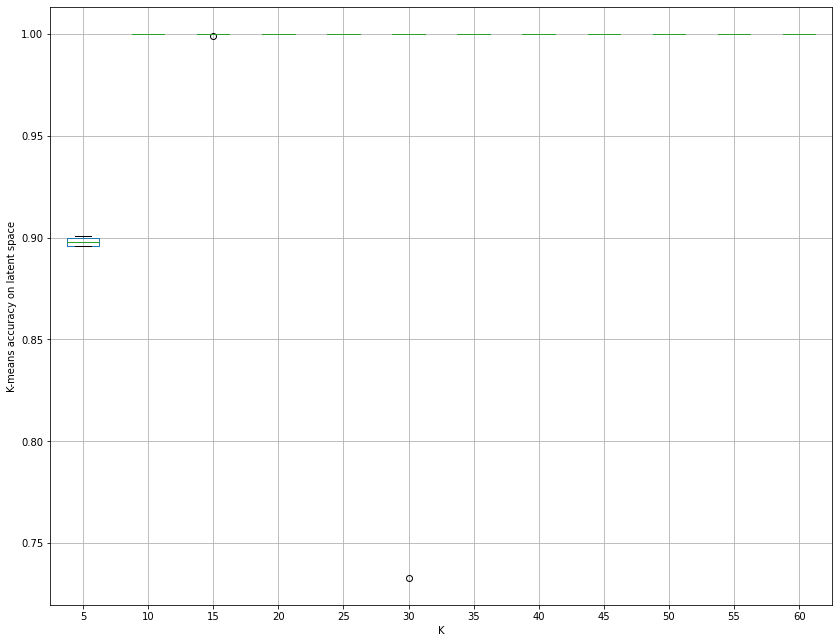

In [ ]:
columns = ['5', '10','15', '20', '25', '30', '35', '40', '45', '50', '55', '60']

df = pd.DataFrame(kmeans_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

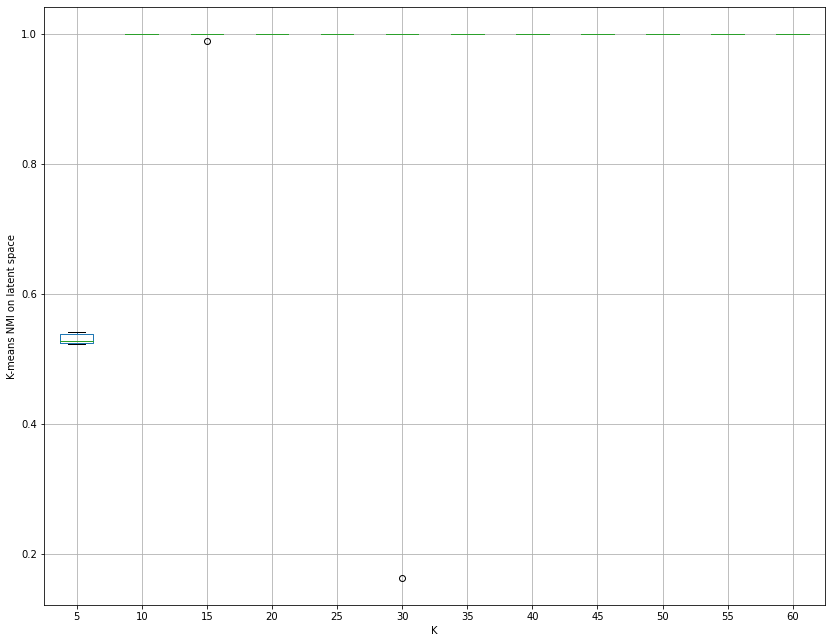

In [ ]:
df = pd.DataFrame(kmeans_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

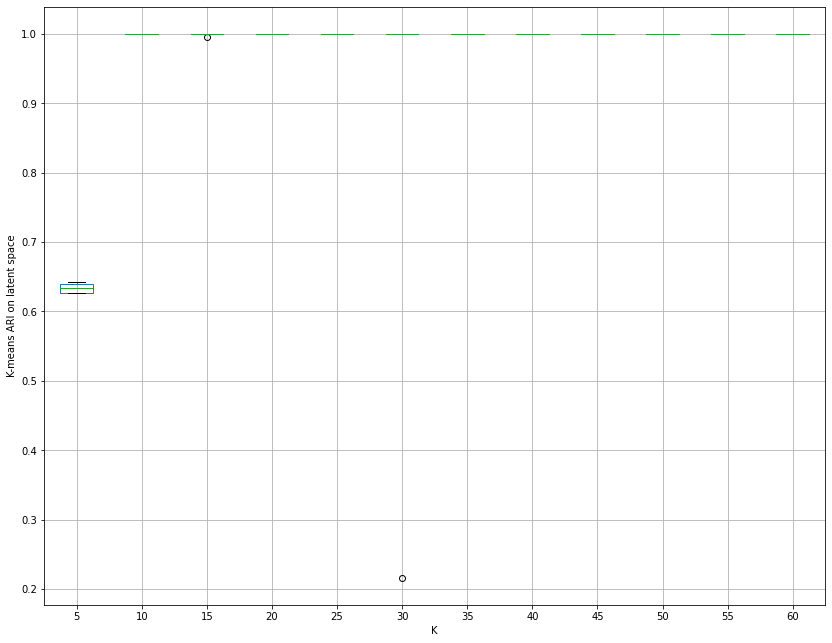

In [ ]:
df = pd.DataFrame(kmeans_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

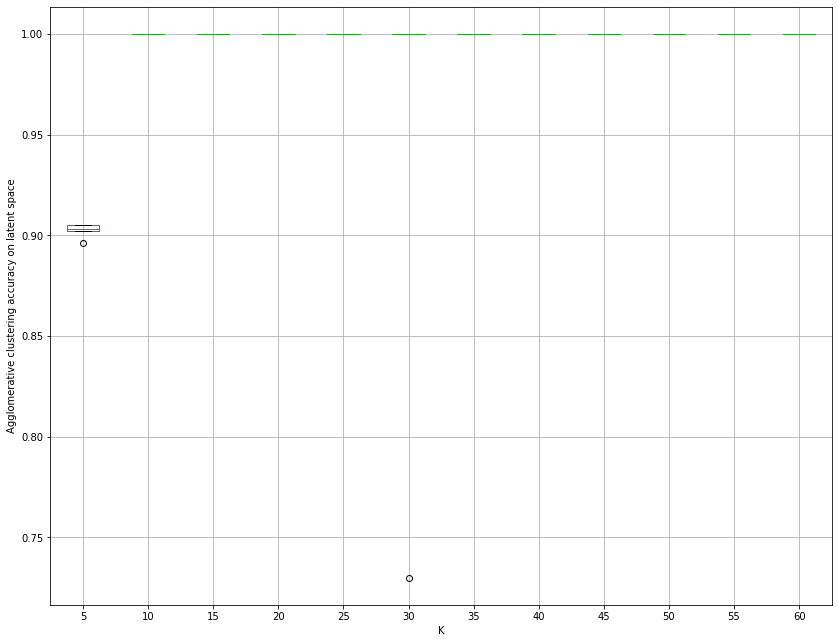

In [ ]:
df = pd.DataFrame(agglo_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

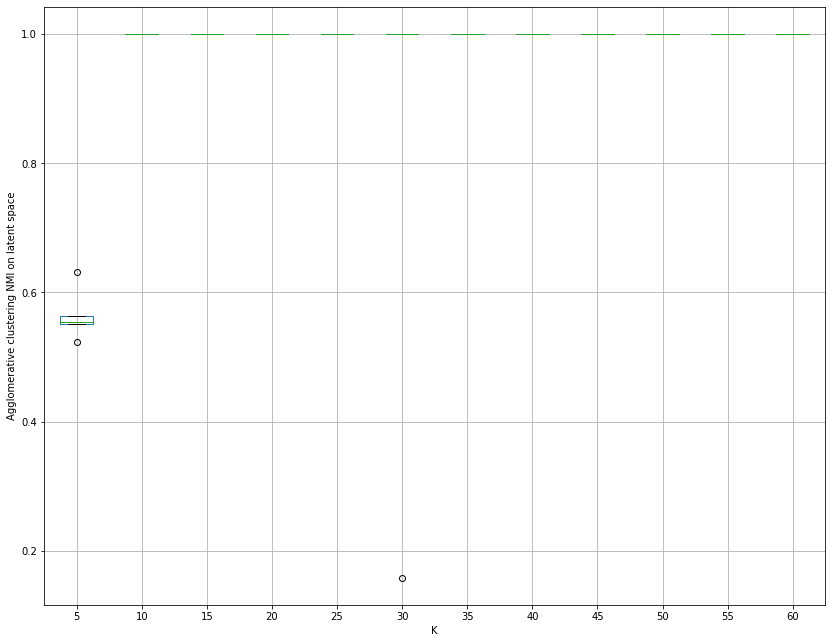

In [ ]:
df = pd.DataFrame(agglo_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

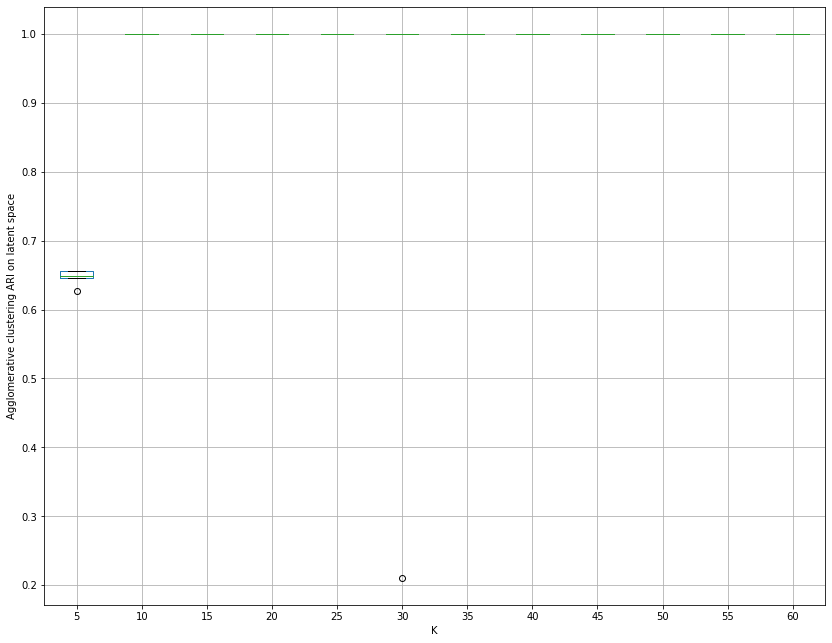

In [ ]:
df = pd.DataFrame(agglo_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

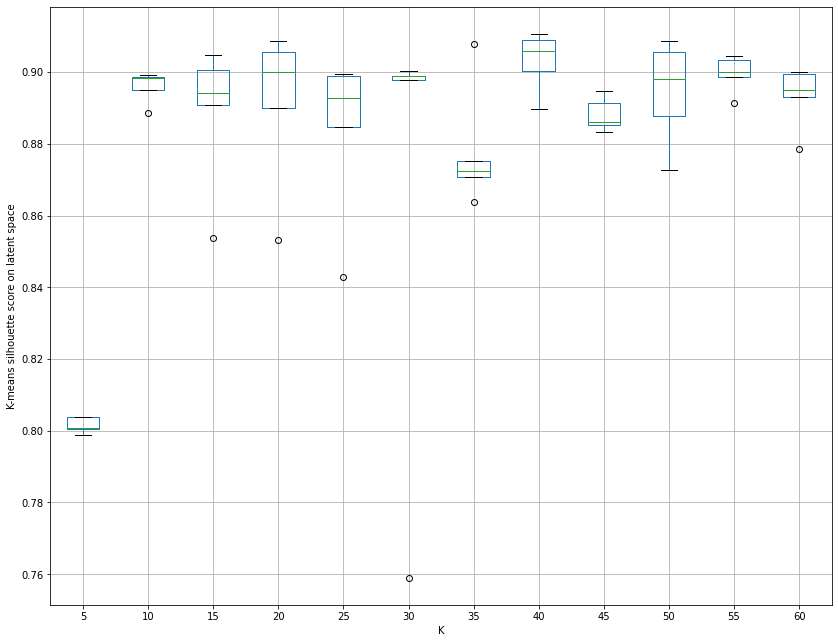

In [ ]:
df = pd.DataFrame(kmeans_silhouette,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means silhouette score on latent space')
boxplot.set_xlabel('K')

# Silhoutte factor

In [ ]:
def get_all_representations(dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension, list_of_cluster_numbers):

  representation_K_tuples = []

  for K in list_of_cluster_numbers:
    print("Creating representation for K =", K, ":\n")
    print("Running k-means...\n")
    kmeans = KMeans(n_clusters=K, n_init=100).fit(datapoints)
    cluster_centers = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_

    # using the autoencoder model on our data

    print("Training autoencoder...\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, cluster_centers, cluster_labels, epochs=epochs)
    print("\n")
    latent_data = autoencoder.encoder(datapoints, device)
    r = latent_data

    representation_K_tuples.append((r,K))

  return representation_K_tuples


In [ ]:
def calculate_silhouette_for_each_representation(representation_tuples, list_of_cluster_numbers):
  representations = [pair[0] for pair in representation_tuples]
  rep_silhouette_list = [[] for i in range(len(representations))]

  for index, rep in enumerate(representations):
    print("Starting process for representation number", index + 1,":\n")
    for K in list_of_cluster_numbers:
      print("Running kmeans for K =", K,"...")
      kmeans = KMeans(n_clusters=K, n_init=100).fit(rep)
      k_means_silhouette_score = silhouette_score(rep, kmeans.labels_)
      rep_silhouette_list[index].append(k_means_silhouette_score)
    print("\n")

  return rep_silhouette_list

In [ ]:
def get_max_silhouette_for_each_representation(rep_silhouette_lst):
  max_silhouette_tuples = [] # keep tuples in the form of (index, max_silhouette)

  for index, silhouette_lst in enumerate(rep_silhouette_lst):
    max = silhouette_lst[0]

    for i in range(1,len(silhouette_lst)):
        if silhouette_lst[i] > max:
            max = silhouette_lst[i]

    max_silhouette_tuples.append((index, max))

  return max_silhouette_tuples

In [ ]:
def calculate_representation_kmeans_acc(representation_tuples, Y):
  representations = [pair[0] for pair in representation_tuples]
  accuracies = []

  for index, rep in enumerate(representations):
    kmeans = KMeans(n_clusters=2, n_init=100).fit(rep)
    kmeans_clusters = kmeans.labels_
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, Y)
    acc = accuracy_score(Y, kmeans_greedy_labels)
    accuracies.append((index,acc))

  return accuracies

In [ ]:
def calculate_normalised_silhouette(max_silhouette_tuples, representation_tuples):
  normalised_silhouette_tuples = []
  representations = [pair[0] for pair in representation_tuples]

  for rep_index, rep in enumerate(representations):
    kmeans = KMeans(n_clusters=2, n_init=100).fit(rep)
    k_means_silhouette_score = silhouette_score(rep, kmeans.labels_)
    normalised_silhouette = (k_means_silhouette_score) / (max_silhouette_tuples[rep_index][1])
    normalised_silhouette_tuples.append((rep_index, normalised_silhouette))


  return normalised_silhouette_tuples

In [ ]:
def silhouette_factor(dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension, list_of_cluster_numbers):
  representation_tuples = get_all_representations(dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension, list_of_cluster_numbers)
  representation_silhouette_list = calculate_silhouette_for_each_representation(representation_tuples, list_of_cluster_numbers)
  max_silhouette_list = get_max_silhouette_for_each_representation(representation_silhouette_list)
  normalised_silhouette_scores = calculate_normalised_silhouette(max_silhouette_list,representation_tuples)
  k_means_accuracies = calculate_representation_kmeans_acc(representation_tuples, labels)
  print(normalised_silhouette_scores)
  print(k_means_accuracies)

  return normalised_silhouette_scores, k_means_accuracies

In [ ]:
normalised_silhouette_scores, k_means_accuracies = silhouette_factor(moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1, list_of_cluster_numbers=[5,10,15,20,25,30,35,40,45,50,55,60])

Creating representation for K = 5 :

Running k-means...

Training autoencoder...

Epoch: 1/50, Loss: 0.034782
Epoch: 2/50, Loss: 0.020784
Epoch: 3/50, Loss: 0.020247
Epoch: 4/50, Loss: 0.020245
Epoch: 5/50, Loss: 0.020069
Epoch: 6/50, Loss: 0.020037
Epoch: 7/50, Loss: 0.019996
Epoch: 8/50, Loss: 0.019909
Epoch: 9/50, Loss: 0.019857
Epoch: 10/50, Loss: 0.019766
Epoch: 11/50, Loss: 0.019728
Epoch: 12/50, Loss: 0.019797
Epoch: 13/50, Loss: 0.019633
Epoch: 14/50, Loss: 0.019569
Epoch: 15/50, Loss: 0.019438
Epoch: 16/50, Loss: 0.019448
Epoch: 17/50, Loss: 0.019360
Epoch: 18/50, Loss: 0.019128
Epoch: 19/50, Loss: 0.018862
Epoch: 20/50, Loss: 0.018166
Epoch: 21/50, Loss: 0.015835
Epoch: 22/50, Loss: 0.014497
Epoch: 23/50, Loss: 0.013636
Epoch: 24/50, Loss: 0.012031
Epoch: 25/50, Loss: 0.011418
Epoch: 26/50, Loss: 0.010858
Epoch: 27/50, Loss: 0.010438
Epoch: 28/50, Loss: 0.010637
Epoch: 29/50, Loss: 0.010304
Epoch: 30/50, Loss: 0.009960
Epoch: 31/50, Loss: 0.009930
Epoch: 32/50, Loss: 0.009757

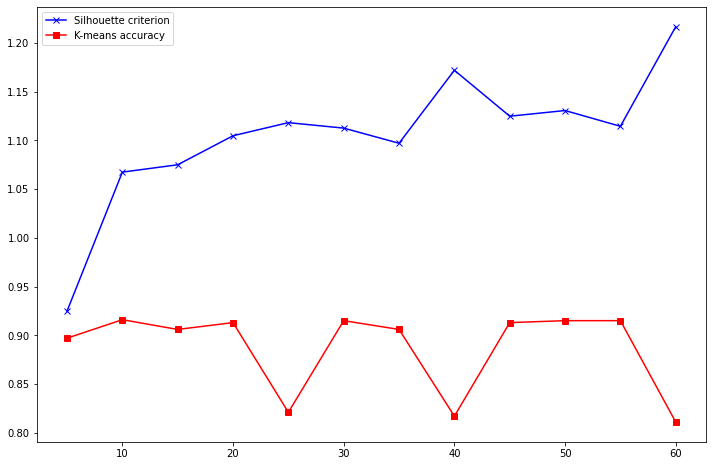

In [ ]:
list_of_cluster_numbers= [5,10,15,20,25,30,35,40,45,50,55,60]

normalised_silhouette_scores = [t[1] for t in normalised_silhouette_scores]
k_means_accuracies = [t[1] for t in k_means_accuracies]

plt.figure(figsize=(12, 8))
plt.plot(list_of_cluster_numbers, normalised_silhouette_scores, c='b', marker='x', label='Silhouette criterion')
plt.plot(list_of_cluster_numbers, k_means_accuracies, c='r', marker='s', label='K-means accuracy')
plt.legend(loc='upper left')
plt.show()